# MIMICScn_HIST
- Reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- **Switched to updated CLM5-GSWP3 inputs (created with ctsm_dev110 tag)**
  - Reduced HR biases in mid- and high lats
- Data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/*/OUTPUT_CN/SPIN

### Notable parameter changes
- Increased MIMICS leaching (function of total DIN pool) 
- Removed density dependent turnover, beta function from Emily's paper
- Introduces flexible microbial C:N, as a function of `fmet` to increase MIC C:N
- Increases FI from inputs to SOMc to increase C:N of total pools
- Decreases KO from 6 to 4, reduces SOMc stocks
- MIMICS and CASA simulation in CN mode and C only.
- **`MIMICS_mod5_GSWP3_KO4`** + `MIMICS_mod5_Conly_KO4`
- `CASACNP_mod4_GSWP3` + `CASACNP_mod4_Conly`

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mp_colors
import matplotlib.lines as mlines
from matplotlib import cm

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

print('xarray version ' + xr.__version__)
%matplotlib inline

xarray version 0.16.1


In [2]:
# open surface dataset for soil properties (clay)
path1= '/project/tss/wwieder/biogeochem_testbed_1.1/'
#surdat = path1 + 'clm_forcing/surfdata_1.9x2.5_hist_16pfts_Irrig_CMIP6_simyr1850_c190304.nc'
#surdat = xr.open_dataset(surdat)

In [3]:
# read in gridinfo file with soil properties:
gridinfo = path1+'GRID_CN/gridinfo_soil_CLM5_GSWP3.csv'
with open(gridinfo) as myfile:
    headRow = next(myfile)

# read column names    
columns = [x.strip() for x in headRow.split(',')]

df = pd.read_csv(gridinfo, header=None, skiprows=1).iloc[:,:-1]
df.columns = columns
#df

In [4]:
path= '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/'
sim = ['MIMICS_mod5_GSWP3_KO4_exudate0_cwdN',
       'MIMICS_mod5_Conly_KO4',
       'CASACNP_mod5_GSWP3_exudate0_cwdN', 
       'CASACNP_mod5_GSWP3_Conly']
year   = [1901,2014]
yearI  = [1901,1905]
yearF  = [2010,2014] # for first and last year of simulations 
fin = [path + i for i in sim]

CNtype = ['CN','C','CN','C']
suffix = ['/OUTPUT_'+j+'/HIST/' for j in CNtype]

fin = [i + j for i, j in zip(fin, suffix)]
models = ['mimics','casaclm']
file = ['ann_'+i+'_pool_flux_'+str(year[0])+'_'+str(year[1])+'.nc' for i in models]
nsim =len(sim)
file

['ann_mimics_pool_flux_1901_2014.nc', 'ann_casaclm_pool_flux_1901_2014.nc']

In [5]:
# files for daily data 
# we'll take the daily climatology below
BigFile = True

if BigFile == True :
    fileDay1901 = [i+'_pool_flux_'+str(yearI[0])+'_'+str(yearI[1])+'_daily.nc' for i in models]
    fileDay2014 = [i+'_pool_flux_'+str(yearF[0])+'_'+str(yearF[1])+'_daily.nc' for i in models]
else:
    fileDay1901 = [i+'_pool_flux_'+str(yearI[0])+'_daily.nc' for i in models]
    fileDay2014 = [i+'_pool_flux_'+str(yearF[1])+'_daily.nc' for i in models]
    
fileDay1901

['mimics_pool_flux_1901_1905_daily.nc', 'casaclm_pool_flux_1901_1905_daily.nc']

### Open datasets and combine MIMICS output into one file
 - This is pretty slow, especially for daily data, can we use DASK on CGD machines?

In [6]:
fileDay1901
fin

['/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/',
 '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_Conly_KO4/OUTPUT_C/HIST/',
 '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/CASACNP_mod5_GSWP3_exudate0_cwdN/OUTPUT_CN/HIST/',
 '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/CASACNP_mod5_GSWP3_Conly/OUTPUT_C/HIST/']

In [7]:
# point to MIMICS files
files_mim = [i + file[0] for i in fin[0:2]]
files_mimDay1901 = [i + fileDay1901[0] for i in fin[0:2] ]
files_mimDay2014 = [i + fileDay2014[0] for i in fin[0:2] ]

sim_mim = ['MIMICS-CN', 'MIMICS-C']
simdim_mim  = xr.DataArray(sim_mim, dims='sim', name='sim')
dims_mim    = [simdim_mim]

# Open annual time series
tmp_mim = xr.open_mfdataset(files_mim,combine='nested',concat_dim=dims_mim)
print(tmp_mim['cOverflow_r'].attrs)

# Open Daily data in 1901-1905
tmp_mimDay1901 = xr.open_mfdataset(files_mimDay1901,combine='nested',
                               concat_dim=dims_mim)
# Open daily data in 2010-2014
tmp_mimDay2014 = xr.open_mfdataset(files_mimDay2014,combine='nested',
                               concat_dim=dims_mim)
print('--- read in MIMICS data ---')

{'long_name': 'Overflow respiration from MICr', 'units': 'gC m-2 day-1', 'cell_methods': 'time: mean'}
--- read in MIMICS data ---


In [8]:
clay = tmp_mimDay2014.cellid.isel(sim=0)

# Map clay based on cell ID and ijcam from gridinfo 
# Inefficient, but works
for i in range(len(df.ijcam)):
    cellid = df.ijcam[i]
    clay = xr.where(clay==cellid, df.clay[i],clay)

print(' - finished mapping clay fraction - ')

 - finished mapping clay fraction - 


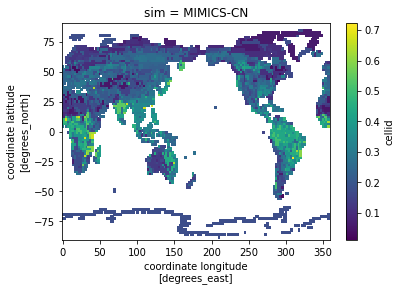

In [9]:
# mask out values > 1 (not replace from index)
clay = clay.where(clay<1)
clay.plot() ;

In [10]:
# point to CASA files
files_cas = [i + file[1] for i in fin]
files_casDay1901 = [i + fileDay1901[1] for i in fin ]
files_casDay2014 = [i + fileDay2014[1] for i in fin  ]

sim_cas = ['MIMICS-CN', 'MIMICS-C','CASA-CN','CASA-C']
simdim_cas  = xr.DataArray(sim_cas, dims='sim', name='sim')
dims_cas    = [simdim_cas]

# Open annual time series
tmp_cas = xr.open_mfdataset(files_cas,combine='nested',concat_dim=dims_cas)
print(' - annual data opened - ')

# Open Daily data in 1901
tmp_casDay1901 = xr.open_mfdataset(files_casDay1901,combine='nested',
                               concat_dim=dims_cas)
print(' -- 1901 daily data opened -- ')
# Open daily data in 2014
tmp_casDay2014 = xr.open_mfdataset(files_casDay2014,combine='nested',
                               concat_dim=dims_cas)

print('---- read in all CASA data ----')

 - annual data opened - 
 -- 1901 daily data opened -- 
---- read in all CASA data ----


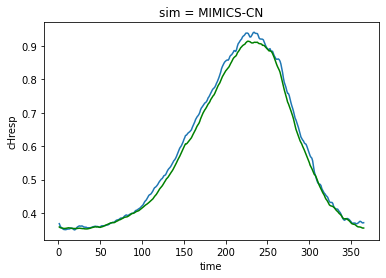

In [11]:
#calculate an annual climatology
# TODO, this is an issue because it removes attribues from the averaged data
if BigFile == True:
    DOY = 5*list(range(1,366))
    tmp_mimDay1901['time'] = DOY
    tmp_mimDay2014['time'] = DOY 
    tmp_mimDay1901.cHresp.mean(['lat','lon']).isel(sim=0,time=slice(0,365)).plot()

    tmp_mimDay1901b = tmp_mimDay1901.groupby('time').mean('time')
    tmp_mimDay2014b = tmp_mimDay2014.groupby('time').mean('time')
    tmp_mimDay1901b.cHresp.mean(['lat','lon']).isel(sim=0).plot(color='g') ;
    
    tmp_casDay1901['time'] = DOY
    tmp_casDay2014['time'] = DOY 
    #tmp_casDay1901.cnpp.mean(['lat','lon']).isel(sim=0,time=slice(0,365)).plot()

    tmp_casDay1901b = tmp_casDay1901.groupby('time').mean('time')
    tmp_casDay2014b = tmp_casDay2014.groupby('time').mean('time')
    #tmp_casDay1901.cnpp.mean(['lat','lon']).isel(sim=0).plot(color='g') ;
    
    # Adjust time dimensions for merging below
    tmp_mimDay2014b['time'] = tmp_mimDay2014b['time']+365
    tmp_casDay2014b['time'] = tmp_casDay2014b['time']+365


### Merge daily data into a single file

In [12]:
if BigFile == True:
    dsmimDay = xr.merge([tmp_mimDay1901b,tmp_mimDay2014b])
    dscasDay = xr.merge([tmp_casDay1901b,tmp_casDay2014b])

    # add metadata back to variables
    mimVar = list(tmp_mimDay1901.keys())
    for i in range(5,len(mimVar)):
        dsmimDay[mimVar[i]].attrs = tmp_mimDay1901[mimVar[i]].attrs
    
    casVar = list(tmp_casDay1901.keys())
    for i in range(5,len(casVar)):
        dscasDay[casVar[i]].attrs = tmp_casDay1901[casVar[i]].attrs
    print(dscasDay[casVar[5]].attrs)
else:
    dsmimDay = xr.merge([tmp_mimDay1901,tmp_mimDay2014])
    dscasDay = xr.merge([tmp_casDay1901,tmp_casDay2014])

# redo the time values for day of year
DOY = 2*list(range(1,366))
dsmimDay['time'] = DOY
dscasDay['time'] = DOY 


{'long_name': 'soil heterotrophic respiration', 'units': 'gC m-2 day-1'}


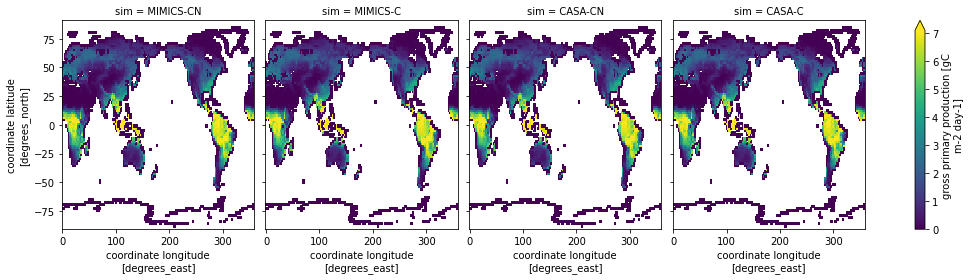

In [13]:
# still need to be careful for non-zero variables
tmp_cas.cgpp.isel(time=0).plot(x="lon", y="lat", col="sim", 
                               robust=True,figsize=[15,4],
                               col_wrap=nsim)  ;

### Combine datasets by simulation

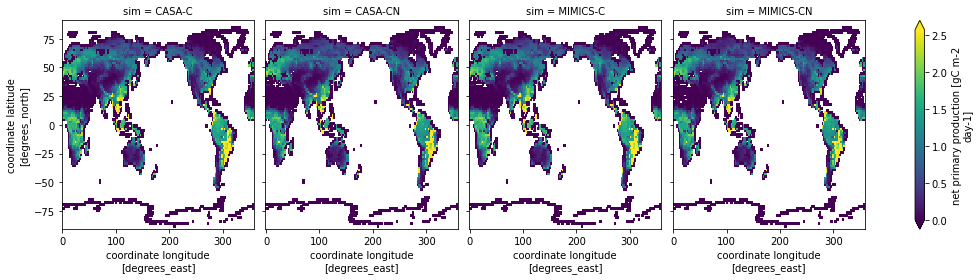

In [14]:
ds = xr.combine_by_coords([tmp_mim,tmp_cas],compat='override',
                          combine_attrs='drop')
dsDay = xr.combine_by_coords([dsmimDay,dscasDay],compat='override',
                             combine_attrs='drop')

ds.cnpp.isel(time=0).plot(x="lon", y="lat", col="sim", 
                          robust=True,figsize=[15,4],
                          col_wrap=nsim)  ;

### Sum soil C & N pools
- uses utilities to calculate / sum variables

In [15]:
# unsure how to subset simulations to run utilities a different way...
# -- Xarray notes: We would love to be able to do indexing with labeled dimension names inside brackets, 
#    but unfortunately, Python does yet not support indexing with keyword arguments --
ds = ds.transpose('sim','lat','lon','time')
test0 = utils.sum_pools_combined(ds.isel(sim=0),'cas',CN='False')
test1 = utils.sum_pools_combined(ds.isel(sim=1),'cas',CN='True')
test2 = utils.sum_pools_combined(ds.isel(sim=2),'mim',CN='False')
test3 = utils.sum_pools_combined(ds.isel(sim=3),'mim',CN='True')
ds= xr.concat([test0,test1,test2,test3],'sim')

dsDay = dsDay.transpose('sim','lat','lon','time')
test0 = utils.sum_pools_combined(dsDay.isel(sim=0),'cas',CN='False')
test1 = utils.sum_pools_combined(dsDay.isel(sim=1),'cas',CN='True')
test2 = utils.sum_pools_combined(dsDay.isel(sim=2),'mim',CN='False')
test3 = utils.sum_pools_combined(dsDay.isel(sim=3),'mim',CN='True')
dsDay= xr.concat([test0,test1,test2,test3],'sim')

# lists to identify simulations later
CNsim = [1,3]  
MIMsim = [2,3]

{'long_name': 'Overflow respiration from MICr',
 'units': 'gC m-2 day-1',
 'cell_methods': 'time: mean'}

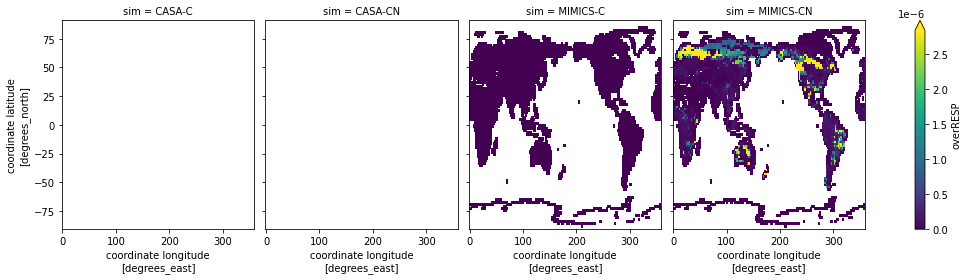

In [16]:
ds['overRESP'] = ds.cOverflow_r + ds.cOverflow_k
ds['overRESP'].isel(time=0).plot(x="lon", y="lat", col="sim", 
                               robust=True,figsize=[15,4],
                               col_wrap=nsim)  ;
ds['overRESP'].attrs = ds.cOverflow_r.attrs 
ds['overRESP'].attrs 

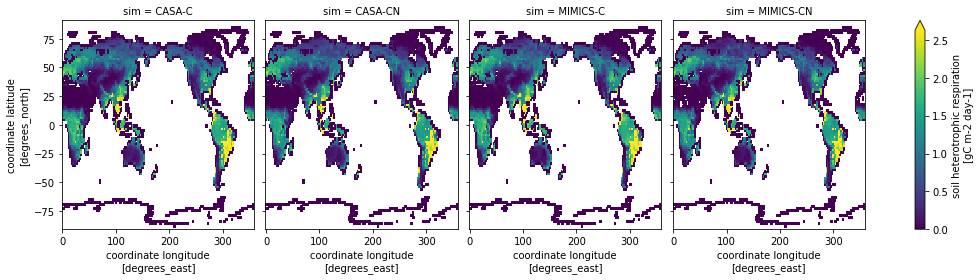

In [17]:
# check for correct fluxes (from utilities)
ds.cresp.isel(time=0).plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim)  ;

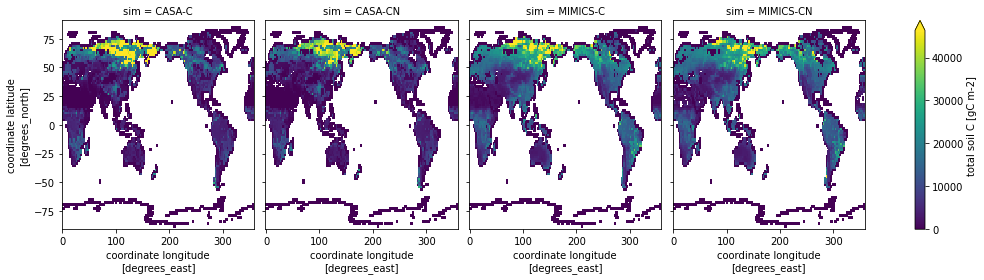

In [18]:
ds.cTOT.isel(time=0).plot(x="lon", y="lat", col="sim", 
                          robust=True,figsize=[15,4],
                          col_wrap=nsim)  ;

In [19]:
# add clay to surface dataset
ds['clay']=clay

#### Mask out low productivity grids (where NPP<10 gC/m2/y)
- Use mean of first 20 years from MIMICScn run to ensure same mask for all simulations

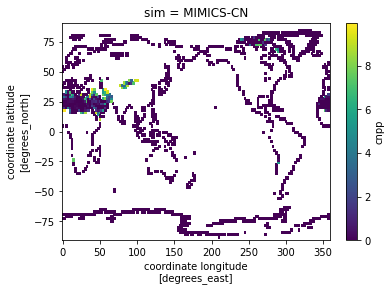

In [20]:
minNPP = 10/365 # npp given in gC/m2/d
initNPP = ds.cnpp.isel(sim=3,time=slice(0,20)).mean(dim='time')
(initNPP.where(initNPP<minNPP)*365).plot() ;                       

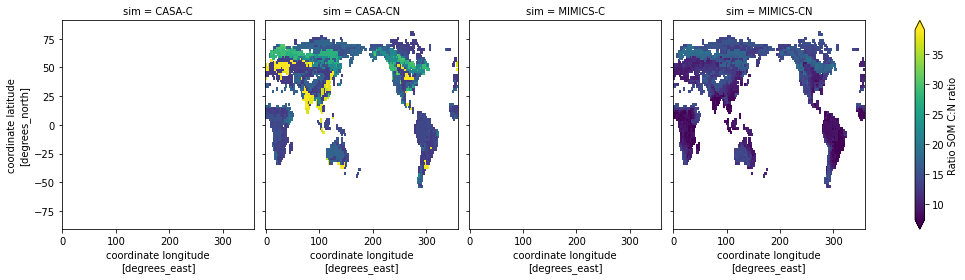

In [21]:
ds = ds.where(initNPP>minNPP)
dsDay = dsDay.where(initNPP>minNPP)
ds.cnTOT.isel(time=0).plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim)  ;

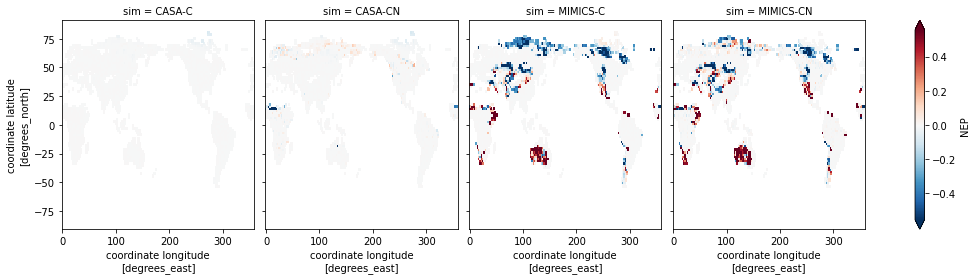

In [22]:
# QUICK LOOK AT MEAN NEP, 1901-1920, converted to gC/m2/y
(ds.NEP.isel(time=slice(0,20)).mean(dim='time')*365).plot(
    x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim)  ;

[7157.1846 7157.1846 7157.1846 7157.1846]


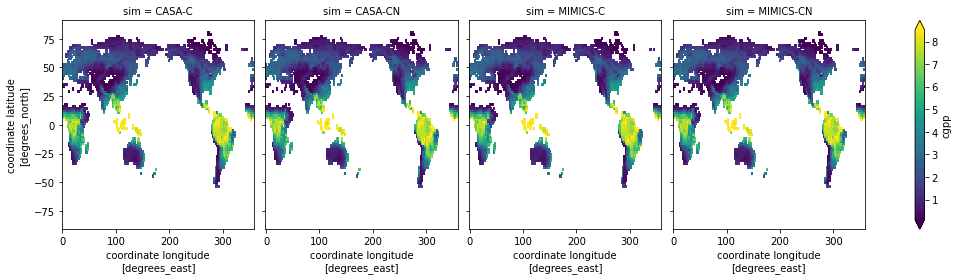

In [23]:
temp2 = (ds.cgpp.isel(time=slice(-20,None)).mean(dim='time'))
print(temp2.sum(['lat','lon']).values)
temp2.plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim);

----
# Calculate zonal means

In [24]:
zon_mean = ds.mean(dim='lon') 

# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']  

### Read observations:
- Microbial C and C:N, Xu et al. 2013  Global Ecology and Biogeography [DOI:10.1111/geb.12029](https://onlinelibrary.wiley.com/doi/10.1111/geb.12029), avail @ https://doi.org/10.3334/ORNLDAAC/1264
- Microbial C  Serna-Chavez et al. 2013 Global Ecology and Biogeography, DOI: 10.1111/geb.12070
- Microbial C:N Gao et al. 2022 Global CHnage Biology https://doi.org/10.1111/gcb.16374, avail @ https://doi.org/10.5281/zenodo.6950624 (microbial C only in mgC/kg)
- Soil C:N_GSDE, Shangguan et al. 2014, doi:10.1002/2013MS000293, avail @ http://globalchange.bnu.edu.cn/research/soilwd.jsp, 
- Soil C HWSD and NCSCD
- Soil C from SoilGrids, v2, 5000m product, regridded to 1 degree and summed 0-1m
- HR Hashimoto et al Biogeosciences 12: 4121-4132. [doi:10.5194/bg-12-4121-2015](https://bg.copernicus.org/articles/12/4121/2015/), downloaded from http://cse.ffpri.affrc.go.jp/shojih/data/index.html

<xarray.DataArray 'CMicSoc' ()>
array(1.54908421)

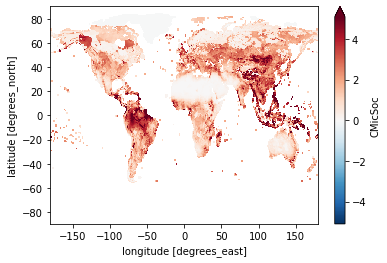

In [25]:
obsIn = "/project/tss/wwieder/soilCN/global_run/"

xuMic = obsIn+'GLOBAL_MICROBIAL_BIOMASS_C_N_P_1264/data/Global_Soil_Microbial_BiomassCN.nc'
dsXu = xr.open_dataset(xuMic)
#dsXu.CN100cm.plot(robust=True);

GaoMic = obsIn+"Gao_MBC.nc"
dsGao = xr.open_dataset(GaoMic)

ChavezMic = obsIn+"Serna-Chavez/smbc_gsqm.nc"
dsChavez = xr.open_dataset(ChavezMic)

ChavezMicSoc = obsIn+"Serna-Chavez/cmicsoc_ratio.nc"
dsChavez2 = xr.open_dataset(ChavezMicSoc)

dsChavez['CMicSoc'] = dsChavez2.Band1 / 100.  #get values to percent
dsChavez['CMicSoc'].plot(robust=True) ;
dsChavez['CMicSoc'].mean()

In [26]:
dsXu
#plt.plot(dsChavez['CMicSoc'].mean(dim='lon'), dsChavez.lat,lw=3, color='k',linestyle='-')


<xarray.Dataset>
Dimensions:   (lat: 360, lon: 720)
Coordinates:
  * lat       (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon       (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
Data variables:
    BIOME     (lat, lon) float64 ...
    SMC30cm   (lat, lon) float32 ...
    SMN30cm   (lat, lon) float32 ...
    SMC100cm  (lat, lon) float32 ...
    SMN100cm  (lat, lon) float32 ...
    CN30cm    (lat, lon) float32 ...
    CN100cm   (lat, lon) float32 ...
Attributes:
    nco_openmp_thread_number:  1
    title:                     Global Dataset of Soil Microbial Biomass Carbo...
    references:                Xu, X., Thornton, P. E. and Post, W. M. (2013)...
    contact:                   Xiaofeng Xu: xux4@ornl.gov, xuxfmail@gmail.com
    institution:               Oak Ridge National Laboratory

In [27]:
GSDE = obsIn+'GSDE/'
GSDEoc = xr.open_dataset(GSDE+'OC5min.nc')
GSDEtn = xr.open_dataset(GSDE+'TN5min.nc')
GSDEoc['CN'] = GSDEoc.OC / GSDEtn.TN.where(GSDEtn.TN>0)
GSDEoc['CNmean'] = GSDEoc.CN.where(GSDEoc.depth<=100).mean(dim='depth')
print('max soil C:N '+str(GSDEoc['CNmean'].max().values))
#mask out silly values
GSDEoc['CNmean2'] = GSDEoc['CNmean'].where(GSDEoc['CNmean']<150)

HWSD = obsIn+'input_data/Soil_obs.nc'
dsOBS = xr.open_dataset(HWSD)

SoilGrids = obsIn+'input_data/SoilGrids_1m_1degree.nc'
dsOBS2 = xr.open_dataset(SoilGrids)

NCSCD = obsIn+'input_data/NCSCD_Circumarctic_100cmSOCC_025deg.nc'
dsNCSCD = xr.open_dataset(NCSCD)

dsHR = xr.open_mfdataset((obsIn+'RH_yr_Hashimoto2015.nc'), decode_times=False,combine='by_coords' )
#dims = time, lev, lat, lon gC/m2/y

dsOBS['HWSD_SOCall'] = dsOBS.HWSD_SOC.sum(dim='nlevsoi').where(dsOBS.HWSD_SOC.isel(nlevsoi=0)>0)
dsOBS['HWSD_SOCall'].attrs = dsOBS.HWSD_SOC.attrs
#dsOBS.HWSD_SOCall.plot();
zon_meanOBS = dsOBS.mean(dim='lon') #kgC/m2
zon_stdOBS = dsOBS.std(dim='lon')  #kgC/m2

zon_meanGSDE = GSDEoc.OC.mean(dim='lon')
zon_stdGSDE = GSDEoc.OC.std(dim='lon')

zon_meanOBS2 = dsOBS2.mean(dim='lon') #kgC/m2
zon_stdOBS2 = dsOBS2.std(dim='lon') #kgC/m2
print('')
print('-- read in observed data -- ')

max soil C:N 5353.0

-- read in observed data -- 


In [28]:
print(dsHR.time)
print(dsOBS2)

<xarray.DataArray 'time' (time: 112)>
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
      dtype=int32)
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 8 ... 104 105 106 107 108 109 110 111
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T
    units:          years since 1901-01-01 00:00:00
    calendar:       365_day
<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288)
Coordinates:
  * 

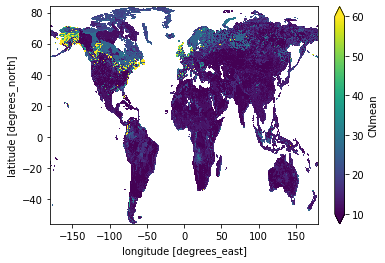

In [29]:
GSDEoc['CNmean'].plot(vmin=10,vmax=60);
#CNtemp = xr.concat([GSDEoc['CNmean'],GSDEoc['CNmean2']],'soilCN')
#print(CNtemp)
#simple = CNtemp.plot(col="soilCN", col_wrap=2,robust=True);

HWSD SOC stocks, 0-1m
1258.7
SoilGrids SOC stocks, 0-1m
1689.4


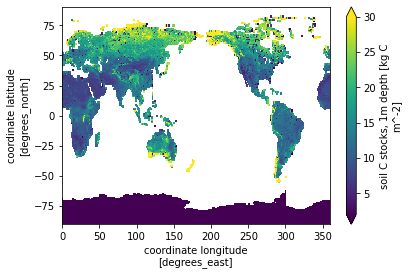

In [30]:
dsOBS2.SOC.plot(vmax=30,vmin=2) ;
dsOBS2.area
# calculate global stocks
# convert km2 to m2 and kg to Pg
print('HWSD SOC stocks, 0-1m')
print(np.round(((dsOBS.HWSD_SOCall * dsOBS2.area.values * 1e6 * \
                 dsOBS2.landfrac.values).sum() * 1e-12 ).values,1))

print('SoilGrids SOC stocks, 0-1m')
print(np.round(((dsOBS2.SOC * dsOBS2.area * 1e6 * \
                 dsOBS2.landfrac).sum() * 1e-12 ).values,1))



In [31]:
dsOBS2

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288)
Coordinates:
  * lon       (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * lat       (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
    area      (lat, lon) float32 29.948368 29.948368 29.948368 ... nan nan nan
    landfrac  (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
Data variables:
    SOC       (lat, lon) float64 0.006136 0.006136 0.006136 ... nan nan nan

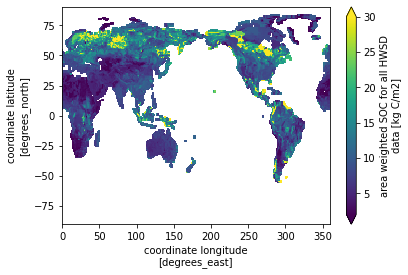

In [32]:
#dsOBS2.area.values
(dsOBS.HWSD_SOCall).plot(vmax=30,vmin=2) ;

/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/
MIMICS_mod5_GSWP3_KO4_exudate0_cwdN


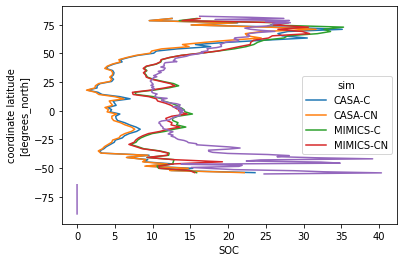

In [33]:
(zon_mean.cTOT.isel(time=0)*1e-3).plot(hue='sim',y='lat') ;
zon_meanOBS2.SOC.plot(y='lat')
print(fin[0])
print(sim[0])

(-5.0, 60.0)

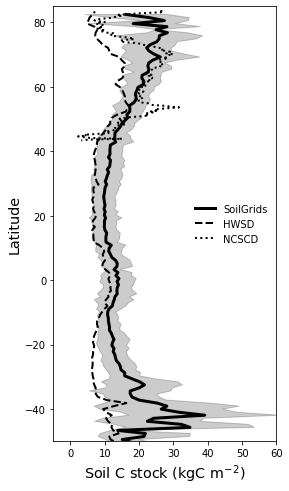

In [34]:
tPlot = 0  #time period to plot
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=[4,8])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)

simLabs = ds['sim'].values.tolist()
color = ['tab:orange','tab:orange','tab:blue','tab:blue','tab:red'] 
lw = [3.5,4,3.,3.5,3.5] 
linestyle= ['--', '-','--', '-', '-']                        

# SOC
v = 'cTOT'
labels = ['SoilGrids','HWSD','NCSCD']
ax1.plot(zon_meanOBS2.get('SOC'), zon_meanOBS2.lat,lw=3, color='k',linestyle='-')
ax1.fill_betweenx(zon_meanOBS2.lat,
                  zon_meanOBS2.get('SOC') + zon_stdOBS2.get('SOC'), 
                  zon_meanOBS2.get('SOC') - zon_stdOBS2.get('SOC'),
                  alpha=0.2, color='k')
ax1.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')
#ax1.fill_betweenx(zon_meanOBS.lat,
#                  zon_meanOBS.get('HWSD_SOCall') + zon_stdOBS.get('HWSD_SOCall'), 
#                  zon_meanOBS.get('HWSD_SOCall') - zon_stdOBS.get('HWSD_SOCall'),
#                  alpha=0.2, color='k')
ax1.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e-1), dsNCSCD.lat,lw=2, color='k',linestyle=':') #convert to kgC

ax1.set_xlabel('Soil C stock (kgC $\mathregular{m^{-2}}$)', fontsize='x-large')
ax1.set_ylabel('Latitude', fontsize='x-large');
ax1.legend(labels=labels, frameon = False, fontsize='medium',loc='center right')
ax1.set_ylim(-50, 85)
ax1.set_xlim(-5, 60)


### Plot zonal means for models and observations

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_3_ZonalSOM.pdf --


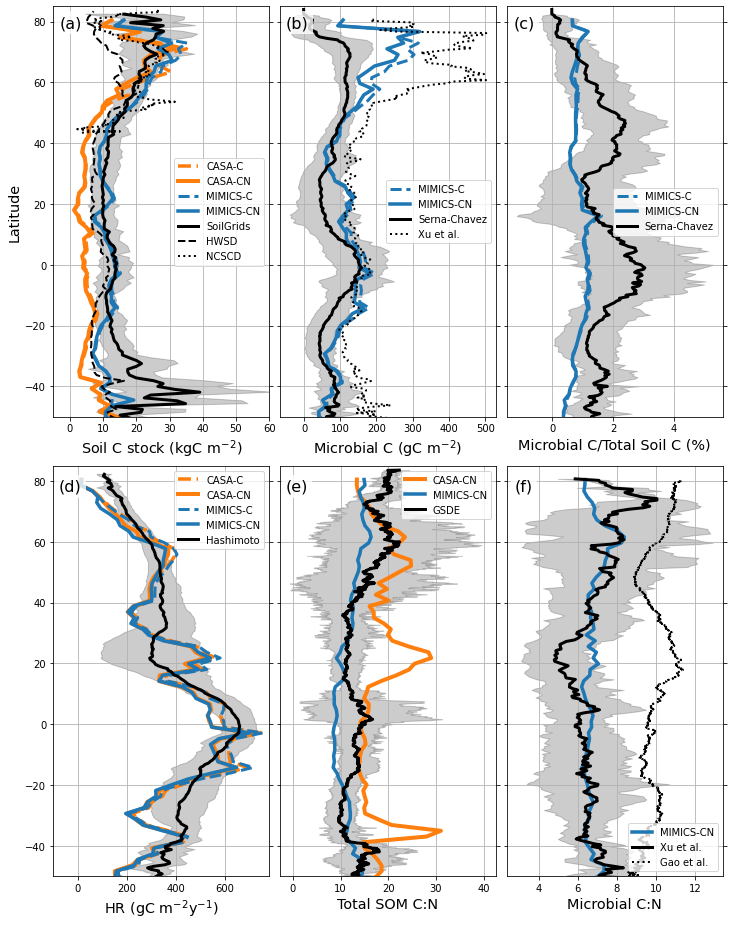

In [35]:
tPlot = 0  #time period to plot
fig, ([ax1, ax2, ax3], [ax4, ax5,ax6]) = plt.subplots(2, 3, sharey=True, figsize=[12,16])
#fig, ([ax1, ax2, ax3, ax4, ax5]) = plt.subplots(1, 5, sharey=True, figsize=[20,8])
# Remove space between axes
fig.subplots_adjust(hspace=0.12, wspace=0.05)

simLabs = ds['sim'].values.tolist()
color = ['tab:orange','tab:orange','tab:blue','tab:blue','tab:red'] 
lw = [3.5,4,3.,3.5,3.5] 
linestyle= ['--', '-','--', '-', '-']                        

# SOC
v = 'cTOT'
labels = simLabs+['SoilGrids','HWSD','NCSCD']
for i in range(nsim):
    ax1.plot((zon_mean.get(v).isel(time=tPlot,sim=i)*1e-3),    
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
# add SoilGrids plot
ax1.plot(zon_meanOBS2.get('SOC'), zon_meanOBS2.lat,lw=3, color='k',linestyle='-')
ax1.fill_betweenx(zon_meanOBS2.lat,
                  zon_meanOBS2.get('SOC') + zon_stdOBS2.get('SOC'), 
                  zon_meanOBS2.get('SOC') - zon_stdOBS2.get('SOC'),
                  alpha=0.2, color='k')
ax1.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')
ax1.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e-1), dsNCSCD.lat,lw=2, color='k',linestyle=':') #convert to kgC

ax1.set_xlabel('Soil C stock (kgC $\mathregular{m^{-2}}$)', fontsize='x-large')
ax1.set_ylabel('Latitude', fontsize='x-large');
ax1.legend(labels=labels, frameon = True, fontsize='medium',loc='center right')
ax1.set_ylim(-50, 85)
ax1.set_xlim(-5, 60)
ax1.yaxis.set_ticks_position('both')
ax1.grid() 

# MICc
v = 'cMICtot'
labels = simLabs[2:nsim]+['Serna-Chavez','Xu et al.'] # Won't use results from ,'Gao et al.', 0-30 cm, mgC/kg
for i in range(2,nsim):
    ax2.plot(zon_mean.get(v).isel(time=tPlot,sim=i), 
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
ax2.plot(dsChavez.Band1.mean(dim='lon'), dsChavez.lat,lw=3, color='k',linestyle='-')
ax2.plot(dsXu.SMC100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k',linestyle=':')

ax2.fill_betweenx(dsChavez.lat,   #add SD by lat
                  dsChavez.Band1.mean(dim='lon') + dsChavez.Band1.std(dim='lon'), 
                  dsChavez.Band1.mean(dim='lon') - dsChavez.Band1.std(dim='lon'),
                  alpha=0.2, color='k')

#x2.fill_betweenx(dsXu.lat,   #add SD by lat
#                  dsXu.SMC100cm.mean(dim='lon') + dsXu.SMC100cm.std(dim='lon'), 
#                  dsXu.SMC100cm.mean(dim='lon') - dsXu.SMC100cm.std(dim='lon'),
#                  alpha=0.2, color='k')

ax2.set_xlabel('Microbial C (gC $\mathregular{m^{-2}}$)', fontsize='x-large');
ax2.legend(labels=labels,frameon = True, fontsize='medium',loc='center right')
ax2.yaxis.set_ticks_position('both')
ax2.grid() 

# MICc_SOC ratio
v = 'relMIC'
labels = simLabs[2:nsim]+['Serna-Chavez'] 
for i in range(2,nsim):
    ax3.plot(zon_mean.get(v).isel(time=tPlot,sim=i), 
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
ax3.plot(dsChavez['CMicSoc'].mean(dim='lon'), dsChavez.lat,lw=3, color='k',linestyle='-')

ax3.fill_betweenx(dsChavez.lat,   #add SD by lat
                  dsChavez['CMicSoc'].mean(dim='lon') + dsChavez['CMicSoc'].std(dim='lon'), 
                  dsChavez['CMicSoc'].mean(dim='lon') - dsChavez['CMicSoc'].std(dim='lon'),
                  alpha=0.2, color='k')

ax3.set_xlabel('Microbial C/Total Soil C (%)', fontsize='x-large');
ax3.legend(labels=labels,frameon = True, fontsize='medium',loc='center right')
ax3.yaxis.set_ticks_position('both')
ax3.grid() 

#----
# HR
v = 'cresp' 
labels = simLabs+['Hashimoto']
for i in range(nsim):
    # fluxes gC/m2/d
    ax4.plot(zon_mean.get(v).isel(time=tPlot,sim=i)*365,    
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
y = dsHR.co2.isel(time=slice(0,20),lev=0).mean('time')
ax4.plot(y.mean(dim='lon'), dsHR.lat,lw=3, color='k')
ax4.fill_betweenx(dsHR.lat,   #add SD by lat
                  y.mean(dim='lon') + y.std(dim='lon'), 
                  y.mean(dim='lon') - y.std(dim='lon'),
                  alpha=0.2, color='k')
ax4.set_xlabel('HR (gC $\mathregular{m^{-2 } y^{-1}}$)', fontsize='x-large')
ax4.legend(labels=labels, frameon = True, fontsize='medium')#,loc=1)
ax4.set_xlim(-100, 780)
ax4.yaxis.set_ticks_position('both')
ax4.grid() 

#----
# Soil C:N
v = 'cnTOT' 
labels = [simLabs[i] for i in [1,3]]+['GSDE']
for i in [1,3]:
    ax5.plot(zon_mean.get(v).isel(time=tPlot,sim=i),   
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
ax5.plot(GSDEoc['CNmean2'].mean(dim='lon'), GSDEoc.lat,lw=3, color='k')
ax5.fill_betweenx(GSDEoc.lat,   #add SD by lat
                  GSDEoc['CNmean2'].mean(dim='lon') + GSDEoc['CNmean2'].std(dim='lon'), 
                  GSDEoc['CNmean2'].mean(dim='lon') - GSDEoc['CNmean2'].std(dim='lon'),
                  alpha=0.2, color='k')
ax5.set_xlabel('Total SOM C:N', fontsize='x-large');
ax5.legend(labels=labels, frameon = True, fontsize='medium')#,loc=0)
ax5.yaxis.set_ticks_position('both')
ax5.grid() 

#----
# MIC C:N
v = 'cnMIC' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
labels = [simLabs[i] for i in [3]]+['Xu et al.','Gao et al.']
for i in [3]:
    ax6.plot(zon_mean.get(v).isel(time=tPlot,sim=i),   
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
ax6.plot(dsXu.CN100cm.mean(dim='lon'), dsXu.lat,lw=3, color='k')
ax6.plot(dsGao.MBCtoN.mean(dim='lon'), dsGao.lat,lw=2, color='k',linestyle=':')
ax6.fill_betweenx(dsXu.lat,   #add SD by lat
                  dsXu.CN100cm.mean(dim='lon') + dsXu.CN100cm.std(dim='lon'), 
                  dsXu.CN100cm.mean(dim='lon') - dsXu.CN100cm.std(dim='lon'),
                  alpha=0.2, color='k')
ax6.set_xlabel('Microbial C:N', fontsize='x-large');
ax6.legend(labels=labels, frameon = True, fontsize='medium',loc='lower right')
ax6.yaxis.set_ticks_position('both')
ax6.grid() 

#----
# add panel labels
ax1.annotate(panel[0], xy=(0.08, 0.96), xycoords=ax1.transAxes, ha='center', va='center',fontsize=16,
            bbox=dict(facecolor='white', alpha=0.8,edgecolor='none'))    
ax2.annotate(panel[1], xy=(0.08, 0.96), xycoords=ax2.transAxes, ha='center', va='center',fontsize=16,
            bbox=dict(facecolor='white', alpha=0.8,edgecolor='none'))    
ax3.annotate(panel[2], xy=(0.08, 0.96), xycoords=ax3.transAxes, ha='center', va='center',fontsize=16,
            bbox=dict(facecolor='white', alpha=0.8,edgecolor='none'))    
ax4.annotate(panel[3], xy=(0.08, 0.95), xycoords=ax4.transAxes, ha='center', va='center',fontsize=16,
            bbox=dict(facecolor='white', alpha=0.8,edgecolor='none'))    
ax5.annotate(panel[4], xy=(0.08, 0.95), xycoords=ax5.transAxes, ha='center', va='center',fontsize=16,
            bbox=dict(facecolor='white', alpha=0.8,edgecolor='none') );    
ax6.annotate(panel[5], xy=(0.08, 0.95), xycoords=ax6.transAxes, ha='center', va='center',fontsize=16,
            bbox=dict(facecolor='white', alpha=0.8,edgecolor='none') );    

fout = fin[0]+'figs/'+sim[0]+'_Fig_3_ZonalSOM.pdf'
plt.savefig(fout)
print(' -- wrote '+fout+' --')

**Figure 3.** Zonal mean plots for MIMICS and CASA simulations (blue and orange lines, respectively) with coupled CN biogeochemistry and C-only configuration (solid and dashed lines, respectively) and relevant observations, (black lines with grey shading showing +/- 1 sigma of mean). Panels show (a) initial soil C stocks (gC m-2, 0-100 cm depth), (b) soil microbial biomass C stocks (gC m-2, 0-100 cm depth), ((d) soil heterotrophic respiration fluxes (gC m-2 y-1),  (e) soil organic matter C:N ratio, and (f) microbial biomass C:N ratios.  See text for references of observations used in this analysis.

- Models show good agreement of stocks & fluxes 
- MIMICS-cn shows weak latitudal variation in soil and microbial C:N. CASA captures is because it uses a pft defined soil C:N

In [36]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None, label=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.95), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:  # here to right of plots
        fig.colorbar(im, ax=ax,shrink=0.40, label=label, pad=0, fraction = 0.1)

    # allows for different colorbars on each plot
    if cb == 2:  # here below plots
        axins = inset_axes(ax,
                    width="90%",  
                    height="5%",
                    loc='lower center',
                    borderpad=-1
                   )
        fig.colorbar(im, cax=axins, orientation="horizontal",
                     #ax=ax,shrink=0.9, pad=.02, fraction = 0.1, location='bottom',
                     ).set_label(label=label,size=12,weight='bold')

# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']  

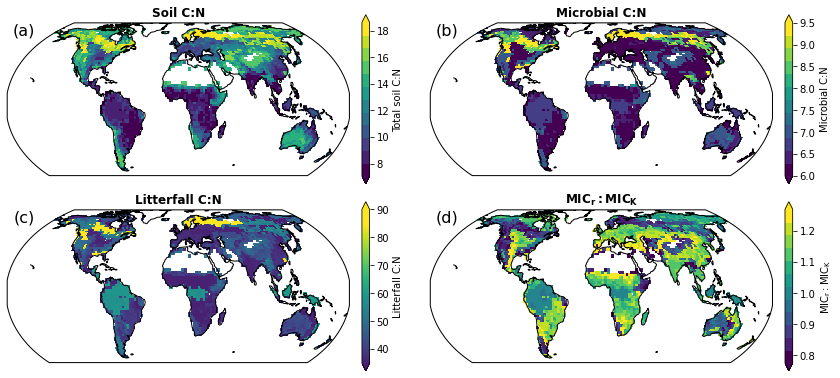

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_4_MIMICS_initial.pdf --


<Figure size 432x288 with 0 Axes>

In [37]:
save = True
ncols = 2
nrows = 2
m2 = '$\mathregular{m^{-2}}$'
y1 = '$\mathregular{y^{-1}}$'
g1 = '$\mathregular{g^{-1}}$'
#  lists of variables, titles & labels
plotVars = ['cnTOT','cnMIC','cnLIT','MICrK']#'relMIC','overRESP']
plotTitle = ['Soil C:N','Microbial C:N','Litterfall C:N',
             '$\mathregular{MIC_{r}:MIC_{K}}$'] 
#             'MIC C: Total C','Overflow Respiration']
plotLabel = ['Total soil C:N','Microbial C:N','Litterfall C:N',
             '$\mathregular{MIC_{r}:MIC_{K}}$'] 
#             '%','mg C '+m2+' '+y1]

# create the plots
fig = plt.figure(figsize=(12,5.33))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c,
                        projection=ccrs.EqualEarth(),
                        ) \
        for r in range(0, nrows) \
        for c in range(0, ncols) ]

# add some data
i = 0
for ax in axes:
    ax.coastlines()
    tempPlot = ds[plotVars[i]].isel(time=slice(0,20),sim=3).sel(
        lat=slice(-60,83)).mean(dim='time')
    #convert daily fluxes to annual
    if i == 5:
        tempPlot = tempPlot*365 *1e3

    if i == 2:
        tempPlot.plot(
        ax=ax, robust=True, 
        transform=ccrs.PlateCarree(),  # this is important!
        cbar_kwargs={'label': plotLabel[i],  
                     "pad": 0.03,
                    },
            #cmap=cm.get_cmap('viridis', 12),
            cmap=utils.truncate_colormap(
                       cmapIn='viridis', minval=0.1, maxval=1,n=12),
            #cmap=utils.truncate_colormap(
            #           cmapIn='Dark2', minval=0.05, maxval=0.84),
            vmax=90,vmin=35,
        )

    else:
        tempPlot.plot(
        ax=ax, robust=True, 
        transform=ccrs.PlateCarree(),  # this is important!
        cbar_kwargs={'label': plotLabel[i],  
                     "pad": 0.03,
                    },
            cmap=cm.get_cmap('viridis', 12),
        )
            
    
            
    ax.set_title(plotTitle[i],fontweight='bold')
    ax.annotate(panel[i], xy=(0.05, 0.95), xycoords=ax.transAxes, 
                ha='center', va='center',fontsize=16)    

    i = i+1

plt.tight_layout()
plt.show()
if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_4_MIMICS_initial.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;

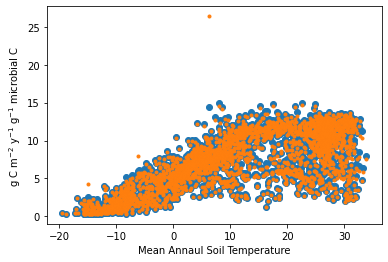

In [38]:
plt.plot(ds.tsoilC.isel(sim=2,time=slice(0,20)).mean('time'),
         ds.specRESP.isel(sim=2,time=slice(0,20)).mean('time'), 
         'o', color='tab:blue') 

plt.plot(ds.tsoilC.isel(sim=3,time=slice(0,20)).mean('time'),
         ds.specRESP.isel(sim=3,time=slice(0,20)).mean('time'), 
         '.', color='tab:orange') 
plt.ylabel('g C '+m2+' '+y1+' '+g1+' microbial C')
plt.xlabel('Mean Annaul Soil Temperature') ;

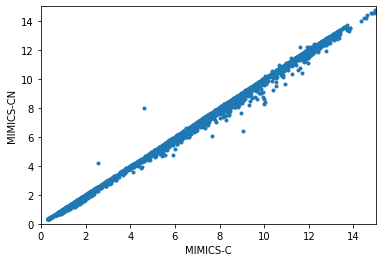

In [39]:
plt.plot(ds.specRESP.isel(sim=2,time=slice(0,20)).mean('time'), 
         ds.specRESP.isel(sim=3,time=slice(0,20)).mean('time'), 
         '.', color='tab:blue') ;
plt.xlabel(ds.sim[2].values)
plt.ylabel(ds.sim[3].values)
plt.xlim(0,15)
plt.ylim(0,15) ;

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


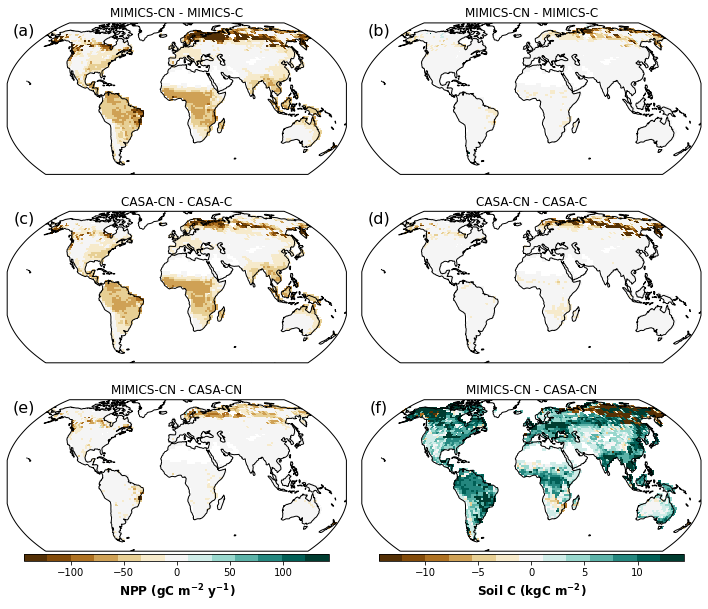

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_S1_CNdifferences.pdf --


<Figure size 432x288 with 0 Axes>

In [40]:
m2 = '$\mathregular{m^{-2}}$'
y1 = '$\mathregular{y^{-1}}$'
g1 = '$\mathregular{g^{-1}}$'

#  lists of variables, titles & labels
plotVars = ['cnpp','cTOT']
plotVars2 = ['NPP, ', 'Soil C, ']
plotTitle = ['MIMICS-CN - MIMICS-C',
             'CASA-CN - CASA-C',
             'MIMICS-CN - CASA-CN']
plotLabel = [('NPP (gC '+m2+' '+y1+')'),
             ('Soil C (kgC '+m2+')')]
vmax = [143.75, 14.375]
ncols = len(plotVars)
nrows = len(plotTitle)             

# create the plots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,8),
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    #print(index)
    i = index[0]
    j = index[1]
    k = k+1
    if i == 0:
        m0, m1 = 2,3
    if i == 1:
        m0, m1 = 0,1
    if i == 2:
        m0, m1 = 1,3
        
    tempPlot = (ds[plotVars[j]].isel(time=slice(0,20),sim=m1).mean(dim='time') - \
                ds[plotVars[j]].isel(time=slice(0,20),sim=m0).mean(dim='time'))
    #convert daily fluxes to annual
    if j == 0: tempPlot = tempPlot*365 
    else: tempPlot = tempPlot*1e-3 
    if i == 2 : 
        map_function(tempPlot, panel=panel[k], ax=ax, title=plotTitle[i], 
                     vmax=vmax[j], vmin=-vmax[j], cmap=cm.get_cmap('BrBG',13),
                     label=plotLabel[j], cb=2)
    else: 
        map_function(tempPlot, panel=panel[k], ax=ax, title=plotTitle[i], 
                     vmax=vmax[j], vmin=-vmax[j], cmap=cm.get_cmap('BrBG',13),cb=0)

plt.tight_layout()
plt.show()
if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_S1_CNdifferences.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;

**Figure S1** Diffferences in inital NPP (gC m-2 y-1, left column) and total soil C (kgC m-2, 0-100 cm depth, right column) that are simulated by MIMICS and CASA models with C-N biogeochemistry, vs. their C-only counterparts.

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


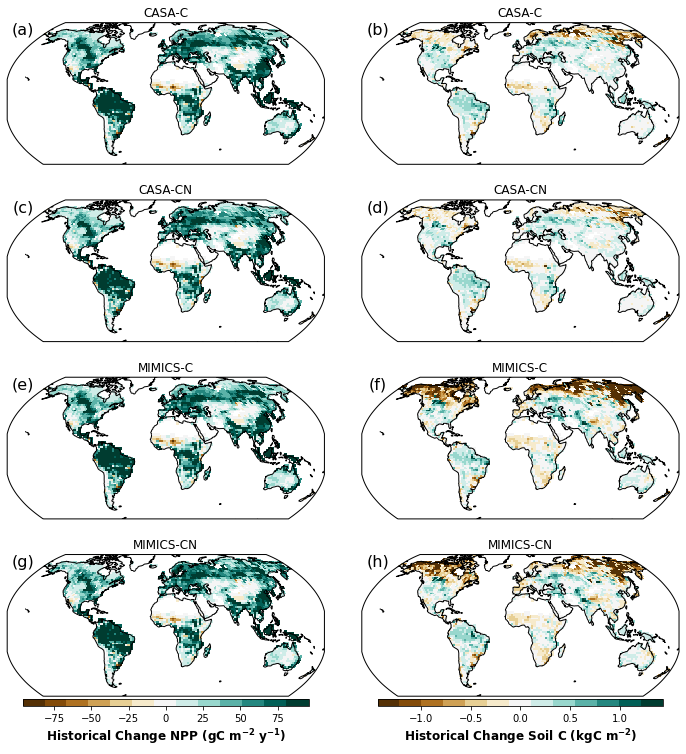

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_S2_soilC_changes.pdf --


<Figure size 432x288 with 0 Axes>

In [41]:
#  lists of variables, titles & labels
plotVars = ['cnpp','cTOT']
plotVars2 = ['NPP, ', 'Soil C, ']
plotLabel = [('Historical Change NPP (gC '+m2+' '+y1+')'),
             ('Historical Change Soil C (kgC '+m2+')')]
plotTitle = ['CASA-C','CASA-CN','MIMICS-C','MIMICS-CN']

vmax = [(143.75/1.5), 1.4375]
ncols = len(plotVars)
nrows = 4             

# create the plots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10),
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    #print(index)
    i = index[0]
    j = index[1]
    k = k+1        
    tempPlot = (ds[plotVars[j]].isel(time=slice(-20,None),sim=i).mean(dim='time') - \
                ds[plotVars[j]].isel(time=slice(0,20),sim=i).mean(dim='time'))
    #convert daily fluxes to annual
    if j == 0: tempPlot = tempPlot*365 
    else: tempPlot = tempPlot*1e-3 
    if i == 3 : 
        map_function(tempPlot, panel=panel[k], ax=ax, title=plotTitle[i], 
                     vmax=vmax[j], vmin=-vmax[j], cmap=cm.get_cmap('BrBG',13),
                     label=plotLabel[j], cb=2)
    else: 
        map_function(tempPlot, panel=panel[k], ax=ax, title=plotTitle[i], 
                     vmax=vmax[j], vmin=-vmax[j], cmap=cm.get_cmap('BrBG',13),cb=0)

plt.tight_layout()
plt.show()
if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_S2_soilC_changes.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;
    

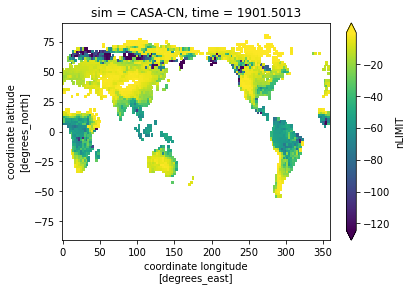

In [42]:
ds['nLIMIT'] = ds.cnpp - ds.cnpp.isel(sim=0)
(ds['nLIMIT']*365).isel(sim=1,time=0).plot(robust=True)

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


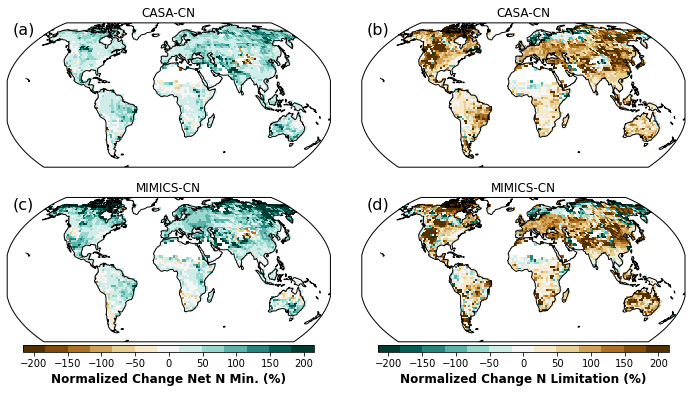

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_S3_N_changes.pdf --


<Figure size 432x288 with 0 Axes>

In [43]:
#  lists of variables, titles & labels
plotVars = ['nNetMineralization','nLIMIT']
plotVars2 = ['Net N Min., ', 'N Limitation, ']
plotLabel = [('Normalized Change Net N Min. (%)'),
             ('Normalized Change N Limitation (%)')]
plotTitle = ['CASA-CN','MIMICS-CN']
cmaps = ['BrBG','BrBG_r','BrBG','BrBG_r'] # f
vmax = [(143.75*1.5), (143.75*1.5)]
ncols = len(plotVars)
nrows = 2             

# create the plots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5),
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    #print(index)
    i = index[0]
    j = index[1]
    k = k+1        
    if i == 0: SIM=1
    else: SIM=3
    # normalized for % change
    tempPlot = (ds[plotVars[j]].isel(time=slice(-20,None),sim=SIM).mean(dim='time') - \
                ds[plotVars[j]].isel(time=slice(0,20),sim=SIM).mean(dim='time')) / \
                ds[plotVars[j]].isel(time=slice(0,20),sim=SIM).mean(dim='time')
    #convert daily fluxes to annual
    tempPlot = tempPlot*365 
    if i == 1 : 
        map_function(tempPlot, panel=panel[k], ax=ax, title=plotTitle[i], 
                     vmax=vmax[j], vmin=-vmax[j], cmap=cm.get_cmap(cmaps[k],13),
                     label=plotLabel[j], cb=2)
    else: 
        map_function(tempPlot, panel=panel[k], ax=ax, title=plotTitle[i], 
                     vmax=vmax[j], vmin=-vmax[j], cmap=cm.get_cmap(cmaps[k],13),cb=0)

plt.tight_layout()
plt.show()
if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_S3_N_changes.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;
    

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


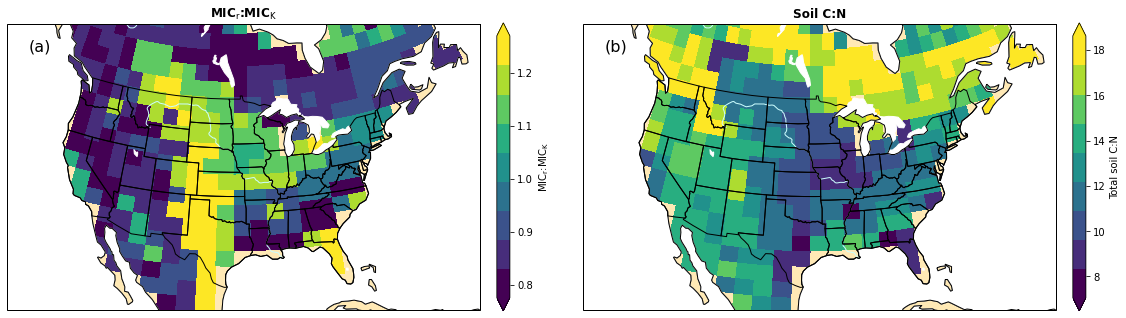

"if save == True:\n    fout = fin[0]+'figs/'+sim[0]+'_Fig_X_conusMaps.pdf'\n    plt.savefig(fout)\n    print(' -- wrote '+fout+' --') ;"

In [44]:
save = True
ncols = 2
nrows = 1
m2 = '$\mathregular{m^{-2}}$'
y1 = '$\mathregular{y^{-1}}$'
g1 = '$\mathregular{g^{-1}}$'
#  lists of variables, titles & labels
plotVars = ['MICrK','cnTOT',]
plotTitle = [r'MIC$_{\rm r}$:MIC$_{\rm K}$','Soil C:N']
plotLabel = [r'MIC$_{\rm r}$:MIC$_{\rm K}$','Total soil C:N']

# create the plots
fig = plt.figure(figsize=(16,4))
conus_proj = ccrs.LambertConformal(central_longitude=-96,central_latitude=39.0)
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c,
                        projection=conus_proj) \
        for r in range(0, nrows) \
        for c in range(0, ncols) ]


axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c,
                        projection=conus_proj,
                        ) \
        for r in range(0, nrows) \
        for c in range(0, ncols) ]

# add some data
i = 0
for ax in axes:
    ax.coastlines()
    tempPlot = ds[plotVars[i]].isel(time=slice(0,20),sim=3).sel(
        lat=slice(-60,83)).mean(dim='time')
    #convert daily fluxes to annual
    if i == 5:
        tempPlot = tempPlot*365 
    tempPlot.plot(
        ax=ax, robust=True, 
        transform=ccrs.PlateCarree(),  # this is important!
        cbar_kwargs={'label': plotLabel[i],  
                     "pad": 0.03,
                    },
        cmap=cm.get_cmap('viridis', 9),
    )
    ax.set_extent([-125,-65,20,55])
    ax.add_feature(cfeature.COASTLINE,zorder=2)
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    ax.add_feature(cfeature.LAKES, facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='#CCFEFF')
    ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')
    ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)

    ax.set_title(plotTitle[i],fontweight='bold')
    ax.annotate(panel[i], xy=(0.07, 0.92), xycoords=ax.transAxes, 
                ha='center', va='center',fontsize=16)    

    i = i+1

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.show()

'''if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_X_conusMaps.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;'''

## Regrid observations for SI plots

In [45]:
print(180/len(ds.lat) )
360/len(ds.lon)

1.875


2.5

In [46]:
import xesmf as xe  # to regrid observations
dsXu_out = xr.Dataset({'lat': (['lat'], ds.lat),
                     'lon': (['lon'], ds.lon)})
# make target grid with lat_b
#dsXu_out = xe.util.grid_global(180/len(ds.lat), 360/len(ds.lon))
GSDEoc_out  = dsXu_out
GSDEoc_out2 = dsXu_out
HWSD_out    = dsXu_out 
HWSD_out2   = dsXu_out 
NCSCD_out  = dsXu_out
SoilGrids_out  = dsXu_out
SoilGrids_out2  = dsXu_out
HR_out = dsXu_out
#dsXu_out.lat_b

In [47]:
#SoilGrids_out2.plot()

In [48]:
#SoilGrids_out.plot() ;

In [49]:
# NOTE: [from xesmf], Data arrays should have (lat, lon) on the right. 
# If not, use DataArray.transpose or numpy.transpose to preprocess the data.
# Note this is also a pretty quick and dirty job, not sure how coastlines are being handled?

XuRegridder = xe.Regridder(dsXu, dsXu_out, 'bilinear',periodic=True, reuse_weights=True)
GSDEregridder = xe.Regridder(GSDEoc, GSDEoc_out, 'bilinear',periodic=True, reuse_weights=True)
HWSDregridder = xe.Regridder(dsOBS['HWSD_SOCall'], HWSD_out, 'bilinear',periodic=True, reuse_weights=True)
NCSCDregridder = xe.Regridder(dsNCSCD, NCSCD_out, 'bilinear',periodic=True, reuse_weights=True)
SoilGridsregridder = xe.Regridder(dsOBS2['SOC'], SoilGrids_out, 'bilinear',periodic=True, reuse_weights=True)
HRregridder = xe.Regridder(dsHR['co2'].isel(lev=0), HR_out, 'bilinear',periodic=False, reuse_weights=True)
#XuRegridder  # print basic regridder information.

Reuse existing file: bilinear_360x720_96x144_peri.nc
Reuse existing file: bilinear_1680x4320_96x144_peri.nc
Reuse existing file: bilinear_192x288_96x144_peri.nc
Reuse existing file: bilinear_268x1440_96x144_peri.nc
Reuse existing file: bilinear_192x288_96x144_peri.nc
Reuse existing file: bilinear_360x720_96x144.nc


In [50]:
dsXu_out = XuRegridder(dsXu)
GSDEoc_out = GSDEregridder(GSDEoc)
HWSD_out = HWSDregridder(dsOBS['HWSD_SOCall'])
NCSCD_out = NCSCDregridder(dsNCSCD)
SoilGrids_out = SoilGridsregridder(dsOBS2['SOC'])
HR_out = HRregridder(dsHR['co2'].isel(lev=0))

dsXu_out = dsXu_out.where(initNPP>minNPP)
GSDEoc_out = GSDEoc_out.where(initNPP>minNPP)
HWSD_out = HWSD_out.where(initNPP>minNPP)
NCSCD_out = NCSCD_out.where(initNPP>minNPP)
HR_out = HR_out.where(initNPP>minNPP)
#SoilGrids_out = SoilGrids_out.where(initNPP>minNPP)
#HR_out.isel()

using dimensions ('lat', 'lon') from data variable BIOME as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable OC as the horizontal dimensions for this dataset.


/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


using dimensions ('lat', 'lon') from data variable NCSCD_SOC as the horizontal dimensions for this dataset.


In [51]:
#SoilGrids_out.sel(lat=slice(-60,83)).plot() ;
((SoilGrids_out * ds.landarea.isel(sim=2)* 1e6).sum()) * 1e-12


<xarray.DataArray ()>
array(1248.36208871)
Coordinates:
    sim      <U8 'MIMICS-C'

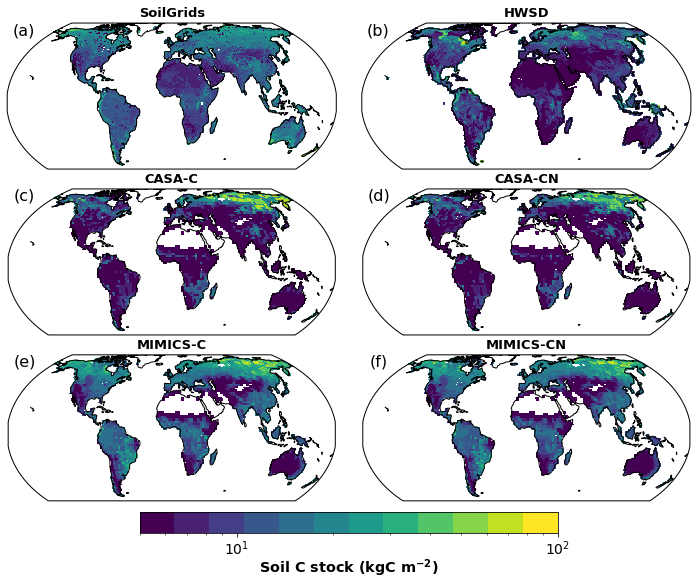

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_S2_ZonalSOM.pdf --


<Figure size 432x288 with 0 Axes>

In [52]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
ncols = 2
nrows = 3
#  lists of variables, titles & labels
plotVars = ['SOC','HWSD_SOCall','cTOT'] #,'NCSCD_SOC'
plotTitle = ['SoilGrids','HWSD']+ simLabs #,'NSCDS'
plotLabel = 'Soil C stock (kgC $\mathregular{m^{-2}}$)'
colorbar = [False,False,False,False,True,True]
# create the plots
fig = plt.figure(figsize=(10,8))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c,
                        projection=ccrs.EqualEarth(),
                        ) \
        for r in range(0, nrows) \
        for c in range(0, ncols) ]

# add some data
i = 0
vmin,vmax = 5,100
for ax in axes:
    ax.coastlines()
    if i == 0:
        tempPlot = dsOBS2['SOC'].sel(lat=slice(-60,83))
    if i == 1:
        tempPlot = dsOBS['HWSD_SOCall'].sel(lat=slice(-60,83))
    #if i == 1: 
    #    tempPlot = NCSCD_out[plotVars[i]].sel(lat=slice(-55,83))*1e-1
    if i > 1:
        tempPlot = ds[plotVars[2]].isel(time=slice(0,20),sim=(i-2)).sel(
        lat=slice(-60,83)).mean(dim='time')*1e-3
    cmap = cm.get_cmap('viridis', 12)
    norm = mp_colors.LogNorm(vmin=vmin, vmax=vmax)
    tempPlot.plot(
        ax=ax, vmin=vmin,vmax=vmax,  
        norm=norm,
        transform=ccrs.PlateCarree(),  # this is important!
        add_colorbar=False,
        cmap=cmap,
    )
    ax.set_title(plotTitle[i],fontweight='bold',size=13)
    ax.annotate(panel[i], xy=(0.05, 0.95), xycoords=ax.transAxes, 
                ha='center', va='center',fontsize=16)    
    i = i+1

# add a colorbar to the bottom of the plot    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.tight_layout()
cb = plt.colorbar(sm, ax=axes, orientation='horizontal', 
                  pad = 0.02,fraction=0.1,shrink=0.6, label = plotLabel,
                  ) ;
cb.ax.tick_params(labelsize=14)
cb.set_label(plotLabel, labelpad=-1, size='x-large',fontweight='bold')
plt.show()

if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_S2_ZonalSOM.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;

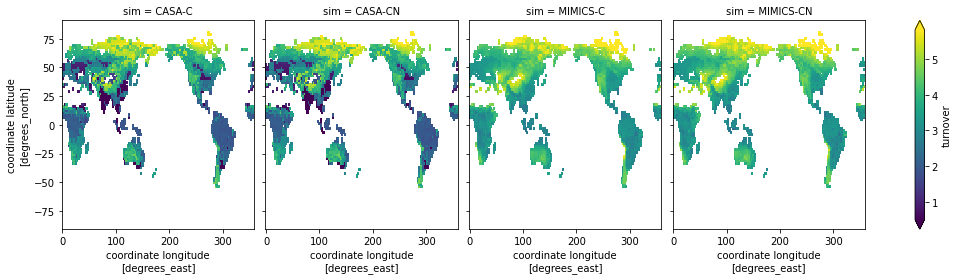

In [53]:
dsInit = ds.isel(time=slice(0,20)).mean('time')
dsInit['turnover'] = dsInit.cTOT / (dsInit.cnpp*365)
np.log(dsInit['turnover']).plot(x="lon", y="lat", col="sim", 
                        robust=True,figsize=[15,4],col_wrap=nsim);

{'long_name': 'soil heterotrophic respiration',
 'units': 'gC m-2 day-1',
 'cell_methods': 'time: mean'}

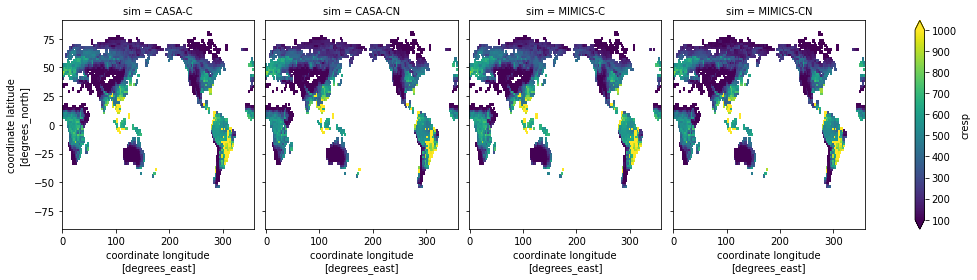

In [54]:
(365*dsInit['cresp']).plot(x="lon", y="lat", col="sim",
                           figsize=[15,4],col_wrap=nsim,
                           vmax=1000,vmin=100);
y = dsHR.co2.isel(time=slice(0,20),lev=0).mean('time')
y.attrs = dsHR.co2.attrs
ds['cresp'].attrs

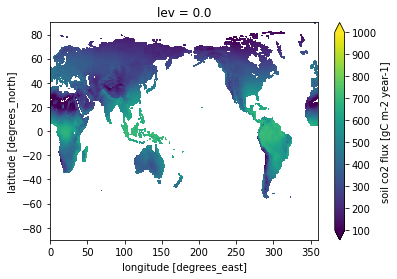

In [55]:
y.where(y>10).plot(vmax=1000,vmin=100) ; 

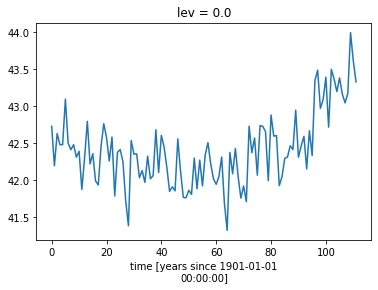

In [56]:
#HR_out.isel(time=0).plot()
#dsXu.CN100cm.plot()
(((HR_out* ds.landarea.isel(sim=2)* 1e6).sum(['lat','lon'])) * 1e-15).plot()
#HR_out

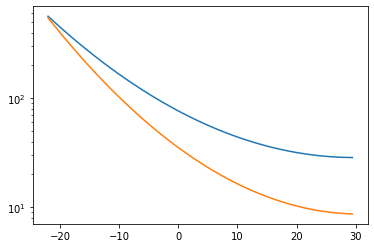

In [57]:
x = dsInit.tairC.isel(sim=3).values.ravel()
x = x[~np.isnan(x)]

ya = dsInit['turnover'].isel(sim=3).values.ravel()
ya = ya[~np.isnan(ya)]

yb = dsInit['turnover'].isel(sim=1).values.ravel()
yb = yb[~np.isnan(yb)]

y   = np.log10(ya)
y2  = np.log10(yb)
quadratic_fit = np.polyfit(x,y,2)
quadraticfunc = np.poly1d(quadratic_fit)

quadratic_fit2 = np.polyfit(x,y2,2)
quadraticfunc2 = np.poly1d(quadratic_fit2)

xd_logquadfit = np.linspace(x.min(), x.max(), 60)
yd_quad = 10. ** quadraticfunc(xd_logquadfit)
yd_quad2 = 10. ** quadraticfunc2(xd_logquadfit)

slope_logspace = quadratic_fit[1] + 2 * quadratic_fit[0]*xd_logquadfit
slope_logspace2 = quadratic_fit2[1] + 2 * quadratic_fit2[0]*xd_logquadfit
inferred_q10 = 10**(10.*(-slope_logspace))
inferred_q102 = 10**(10.*(-slope_logspace2))

#plt.plot(x, ya, '.', label='MIMICS-CN',color=colors[1],alpha=0.9) ;
plt.plot(xd_logquadfit, yd_quad);
plt.yscale('log');
#plt.plot(x, yb, '.', label='CASA-CN',color=colors[0],alpha=0.9) ;
plt.plot(xd_logquadfit, yd_quad2);


In [58]:
x = (dsInit['cMICtot'].isel(sim=3) / dsInit['cMICtot'].isel(sim=2)).values.ravel()
x = x[~np.isnan(x)]
x
#dsInit['cMICtot'].isel(sim=3)

np.log([0.8,1,1.2])

array([-0.22314355,  0.        ,  0.18232156])

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_2_TurnoverTime.pdf --


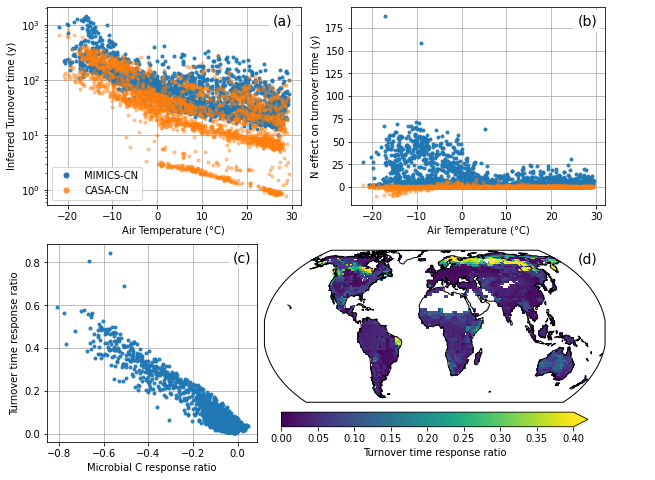

In [59]:
from matplotlib import gridspec
fig = plt.figure(figsize=[10,8])
gs = fig.add_gridspec(2, 13)

colors = ['tab:orange','tab:blue']
#fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,8),
#                         subplot_kw=dict(projection=ccrs.Robinson()))
for i in range(4):
    if i == 0:
        ax1 = fig.add_subplot(gs[0, 0:6])
        ax1.plot(dsInit.tairC.isel(sim=3), dsInit['turnover'].isel(sim=3), '.', 
             label='MIMICS-CN',color=colors[1],alpha=0.9) 
        ax1.plot(dsInit.tairC.isel(sim=1), dsInit['turnover'].isel(sim=1), '.', 
                 label='CASA-CN', color=colors[0],alpha=0.4) ; 
        ax1.annotate(panel[i], xy=(0.94, 0.94), xycoords=ax.transAxes, ha='center', va='center',fontsize=14, 
                    bbox=dict(facecolor='white', alpha=0.8,edgecolor='none'))    
        handles, labels = ax1.get_legend_handles_labels()
        handle_list, label_list = [], []
        for handle, label in zip(handles, labels):
            if label not in label_list:
                handle_list.append(handle)
                label_list.append(label)
        legend = ax1.legend(handle_list, label_list, frameon = True, fontsize='medium',loc='lower left')
        legend.legendHandles[0]._legmarker.set_markersize(10)
        legend.legendHandles[1]._legmarker.set_markersize(10)
        legend.legendHandles[0]._legmarker.set_alpha(1)
        legend.legendHandles[1]._legmarker.set_alpha(0.8)
        ax1.set_xlabel('Air Temperature ('+u'\N{DEGREE SIGN}'+'C)')
        ax1.set_ylabel('Inferred Turnover time (y)')
        ax1.set_yscale('log');
        ax1.annotate(panel[i], xy=(0.93, 0.93), xycoords=ax1.transAxes, ha='center', va='center',fontsize=14,
                    bbox=dict(facecolor='white', alpha=0.8,edgecolor='none'))    
        ax1.grid();
    if i == 1:
        ax2 = fig.add_subplot(gs[0, 7:])
        y1 = (dsInit['turnover'].isel(sim=1) - dsInit['turnover'].isel(sim=0))
        y2 = (dsInit['turnover'].isel(sim=3) - dsInit['turnover'].isel(sim=2))
        ax2.plot(dsInit.tairC.isel(sim=3), y2, '.', label='MIMICS',color=colors[1],alpha=0.9) 
        ax2.plot(dsInit.tairC.isel(sim=1), y1, '.', label='CASA', color=colors[0],alpha=0.4) ; 
        ax2.annotate(panel[i], xy=(0.93, 0.93), xycoords=ax2.transAxes, ha='center', va='center',fontsize=14,
                    bbox=dict(facecolor='white', alpha=0.8,edgecolor='none'))    
        ax2.set_xlabel('Air Temperature ('+u'\N{DEGREE SIGN}'+'C)')
        ax2.set_ylabel('N effect on turnover time (y)')
        ax2.grid();

    if i == 2:
        ax3 = fig.add_subplot(gs[1, 0:5])
        # could plot this as effect size, but I think it's less meaningful...
        x = np.log(dsInit['cMICtot'].isel(sim=3) / dsInit['cMICtot'].isel(sim=2))
        y = np.log(dsInit['turnover'].isel(sim=3) / dsInit['turnover'].isel(sim=2))
        y.attrs['long_name'] = 'Turnover time response ratio'
        ax3.plot(x, y, '.', label='MIMICS',color=colors[1],alpha=0.9) 
        ax3.annotate(panel[i], xy=(0.93, 0.93), xycoords=ax3.transAxes, ha='center', va='center',fontsize=14,
                    bbox=dict(facecolor='white', alpha=0.8,edgecolor='none') )    
        ax3.set_ylabel(y.attrs['long_name'])
        ax3.set_xlabel('Microbial C response ratio')
        ax3.grid();

    if i == 3:
        ax4 = fig.add_subplot(gs[1, 5:],
                        projection=ccrs.EqualEarth())
        y.sel(lat=slice(-60,83)).plot(robust=True,transform=ccrs.PlateCarree(),ax=ax4,
                                      vmax=0.4,vmin=0,
                                      cbar_kwargs={
                                        "orientation": "horizontal",
                                        #"label": "custom label",
                                        "pad": 0.05,
                                        "shrink": 0.9,
                                        },  # passed to plt.colorbar
                                     ) ;
        ax4.annotate(panel[i], xy=(0.95, 0.94), xycoords=ax4.transAxes, ha='center', va='center',fontsize=14,
                    bbox=dict(facecolor='white', alpha=0.8,edgecolor='none'))    
        ax4.set_ylabel(None)
        ax4.set_xlabel(None) 
        ax4.coastlines()
        #map_function(tempPlot, panel=panel[i], ax=ax, title=plotTitle[i],cb=2) 
                     #vmax=vmax[j], vmin=-vmax[j], cmap=cm.get_cmap('BrBG',9),
                     #label=plotLabel[j], 
        
fig.tight_layout()
if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_2_TurnoverTime.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;
    

**Figure 2** inferred soil C turnover times as a function of mean annual air temperature for all grid cells for MIMICS-CN and CASA-CN simulations (blue & organge points, respectively)

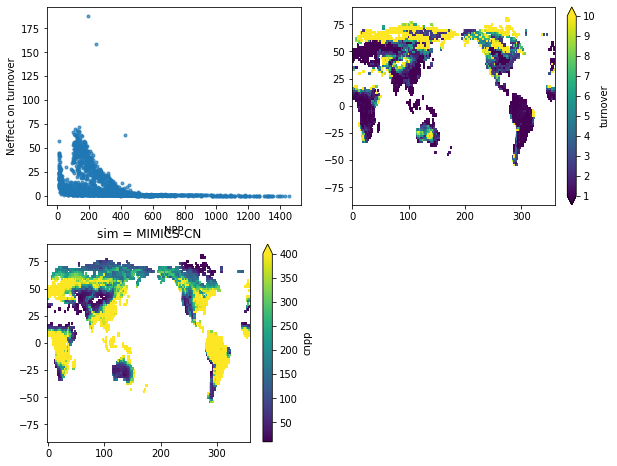

In [60]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(dsInit.cnpp.isel(sim=3)*365, y2, '.', label='MIMICS',color=colors[1],alpha=0.7) ;
plt.xlabel('NPP')
plt.ylabel('Neffect on turnover')

plt.subplot(222)
y2.plot(vmin=1,vmax=10) ;
plt.xlabel(None)
plt.ylabel(None) ;

plt.subplot(223)
anpp = (dsInit.cnpp.isel(sim=3)*365)
anpp.plot(vmin=10,vmax=400) ;
plt.xlabel(None)
plt.ylabel(None) ;

N effects on soil turnover largely in lower productivity, colder grid cells, likely because of NPP controls on microbial turnover in MIMICS, which reduce microbial biomass

Text(0.5, 0, 'Neffect on NPP (log(CN/C))')

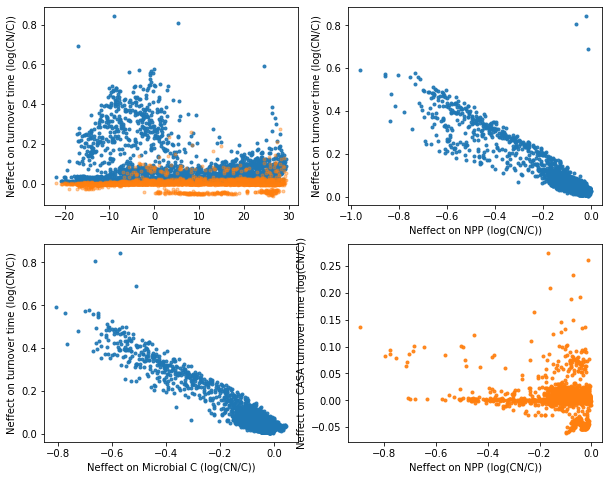

In [61]:
y1 = np.log(dsInit['turnover'].isel(sim=1) / dsInit['turnover'].isel(sim=0))
y2 = np.log(dsInit['turnover'].isel(sim=3) / dsInit['turnover'].isel(sim=2))

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(dsInit.tairC.isel(sim=3), y2, '.', label='MIMICS',color=colors[1],alpha=0.9) 
plt.plot(dsInit.tairC.isel(sim=1), y1, '.', label='CASA', color=colors[0],alpha=0.4) ; 
plt.xlabel('Air Temperature')
plt.ylabel('Neffect on turnover time (log(CN/C))')


xa = np.log(dsInit['cnpp'].isel(sim=3) / dsInit['cnpp'].isel(sim=2))
xb = np.log(dsInit['cMICtot'].isel(sim=3) / dsInit['cMICtot'].isel(sim=2))

plt.subplot(222)
plt.plot(xa, y2, '.', label='MIMICS',color=colors[1],alpha=0.9) 
plt.ylabel('Neffect on turnover time (log(CN/C))')
plt.xlabel('Neffect on NPP (log(CN/C))')

plt.subplot(223)
plt.plot(xb, y2, '.', label='MIMICS',color=colors[1],alpha=0.9) ;
plt.ylabel('Neffect on turnover time (log(CN/C))')
plt.xlabel('Neffect on Microbial C (log(CN/C))')

plt.subplot(224)
xa = np.log(dsInit['cnpp'].isel(sim=1) / dsInit['cnpp'].isel(sim=0))
plt.plot(xa, y1, '.', label='CASA',color=colors[0],alpha=0.9) 
plt.ylabel('Neffect on CASA turnover time (log(CN/C))')
plt.xlabel('Neffect on NPP (log(CN/C))')

## Code below to write out table of global means
- Table 1: Initial stocks & fluxes (1901-1920 means)
- Table 2: Change in global stocks and fluxes (mean 2000-2014)
GPP, NPP, HR, Soil C, microbial biomass, MIC:SOM, SOM C:N, microbial C:N

In [62]:
def globalSum ( varIn, area=ds.landarea.isel(sim=nsim-1) *1e6, timeC=1, conversion=1e-15, units=None, pt=False):
    "Global weighted sum of fluxes & states"
    temp = varIn * area 
    temp = temp.sum(dim=('lat','lon')) * conversion * timeC
    if pt==True:
        print(varIn.attrs['long_name']+' '+str(np.round(temp.values,1))+' Pg C')
    return(temp)

def globalMean ( varIn, area=ds.landarea.isel(sim=nsim-1) *1e6, timeC=1, conversion=1, units=None, pt=False):
    "Global weighted mean"
    temp = varIn * area / area.sum()
    temp = temp.sum(dim=('lat','lon')) * conversion * timeC
    if pt==True:
        print(varIn.attrs['long_name']+' '+str(np.round(temp.values,1))+' Pg C')
    return(temp)

d2y = 365
#MIMcnANN['cgpp'].isel(time=slice(0,20)).mean('time')
print('gpp')
print(np.round(globalSum(ds['cgpp'].isel(time=slice(0,20)).mean('time'),timeC=d2y, pt=False),1).values)
print('npp')
print(np.round(globalSum(ds['cnpp'].isel(time=slice(0,20)).mean('time'),timeC=d2y, pt=False),1).values)
print('cLIT, MIMICS')
print(np.round(globalSum((ds['cLITm'].isel(sim=3)+ds['cLITs'].isel(sim=3)).isel(
    time=slice(0,20)).mean('time'), pt=False),1).values)
print('cLIT, CASA')
print(np.round(globalSum((ds['clitmetb'].isel(sim=1)+ds['clitstr'].isel(sim=1)).isel(
    time=slice(0,20)).mean('time'), pt=False),1).values)
print('cTOT')
print(np.round(globalSum(ds['cTOT'].isel(time=slice(0,20)).mean('time'), pt=False),1).values)


gpp
[106.1 106.1 106.1 106.1]
npp
[42.  38.9 42.  38.2]
cLIT, MIMICS
343.5
cLIT, CASA
63.8
cTOT
[ 996.8  887.2 1582.5 1516.4]


In [63]:
ds.cVEG

<xarray.DataArray 'cVEG' (sim: 4, lat: 96, lon: 144, time: 114)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * sim      (sim) object 'CASA-C' 'CASA-CN' 'MIMICS-C' 'MIMICS-CN'
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
  * time     (time) float32 1901.5013 1902.5013 ... 2013.5013 2014.5013
Attributes:
    long_name:  total veg C
    units:      gC m-2

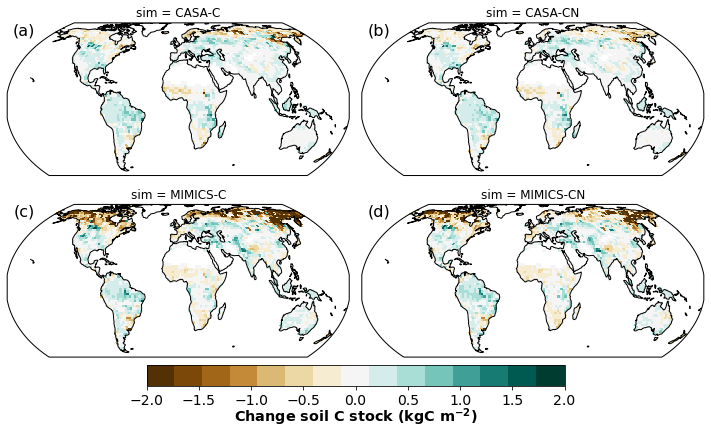

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_SX_change_cTOT.pdf --


<Figure size 432x288 with 0 Axes>

In [64]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
ncols = 2
nrows = 2
#  lists of variables, titles & labels
plotLabel = 'Change soil C stock (kgC $\mathregular{m^{-2}}$)'
colorbar = [False,False,False,True]
# create the plots
fig = plt.figure(figsize=(10,6))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c,
                        projection=ccrs.EqualEarth(),
                        ) \
        for r in range(0, nrows) \
        for c in range(0, ncols) ]

# add some data
i = 0
vmin,vmax = -2,2
for ax in axes:
    ax.coastlines()
    tempPlot = (ds['cTOT'].isel(time=slice(-20,None),sim=(i)).mean(dim='time') - 
                ds['cTOT'].isel(time=slice(0,20),sim=(i)).mean(dim='time'))
    tempPlot = tempPlot.sel(lat=slice(-60,83))*1e-3
    cmap = cm.get_cmap('BrBG', 15)

    tempPlot.plot(
        ax=ax, vmin=vmin,vmax=vmax,
        transform=ccrs.PlateCarree(),  # this is important!
        add_colorbar=False,
        cmap=cmap,
    )
    #ax.set_title(plotTitle[i],fontweight='bold',size=13)
    ax.annotate(panel[i], xy=(0.05, 0.95), xycoords=ax.transAxes, 
                ha='center', va='center',fontsize=16)    
    i = i+1

# add a colorbar to the bottom of the plot    
#sm = plt.cm.ScalarMappable(cmap=cmap)
plt.tight_layout()
#sm.set_array([])

cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), 
                  ax=axes, orientation='horizontal',
                  pad = 0.02,fraction=0.1,shrink=0.6, label = plotLabel,
                  ) ;
cb.ax.tick_params(labelsize=14)
cb.mappable.set_clim(vmin, vmax)
cb.set_label(plotLabel, labelpad=-1, size='x-large',fontweight='bold')
plt.show()

if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_SX_change_cTOT.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;
    


In [65]:
sm

In [66]:
row_names = ['cgpp','cnpp','cresp','cTOT','cMICtot','relMIC','nNetMineralization','cnTOT','cnMIC','cVEG']
col_names = simLabs
nrow = len(row_names)
ncol = len(col_names)
init_table = np.empty((nrow,ncol))
fin_table = np.empty((nrow,ncol))

for i in range(ncol):
    for j in range(nrow):
        din = ds.isel(sim=i,time=slice(0,20)).mean('time') 
        din2 = ds.isel(sim=i,time=slice(-20,None)).mean('time') 
        #convert fluxes appropriately
        if j <=2:
            init_table[j,i] = np.round(globalSum(din[row_names[j]],timeC=d2y, pt=False),1).values
            fin_table[j,i] = np.round(globalSum(din2[row_names[j]],timeC=d2y, pt=False),1).values 
        # soil C stocks
        if j == 3 or j == 9:
            init_table[j,i] = np.round(globalSum(din[row_names[j]],pt=False),0).values
            fin_table[j,i] = np.round(globalSum(din2[row_names[j]],pt=False),0).values
        # MIC C stocks, Pg C
        if j == 4 :
            init_table[j,i] = np.round(globalSum(din[row_names[j]],pt=False),1).values
            fin_table[j,i] = np.round(globalSum(din2[row_names[j]],pt=False),1).values
        if j == 5 :
            init_table[j,i] = np.round(globalMean(din[row_names[j]],pt=False),3).values
            fin_table[j,i] = np.round(globalMean(din2[row_names[j]],pt=False),3).values

        # net Mineraliztion, Tg N / year
        if j == 6 :
            init_table[j,i] = np.round(globalSum(din[row_names[j]],timeC=d2y, conversion=1e-12, pt=False),0).values
            fin_table[j,i] = np.round(globalSum(din2[row_names[j]],timeC=d2y, conversion=1e-12, pt=False),0).values

        # soil C:N
        if j == 7 :
            init_table[j,i] = np.round(globalMean(din[row_names[j]],pt=False),2).values
            fin_table[j,i] = np.round(globalMean(din2[row_names[j]],pt=False),2).values

        # MIC C:N
        if j == 8 :
            init_table[j,i] = np.round(globalMean(din[row_names[j]],pt=False),2).values
            fin_table[j,i] = np.round(globalMean(din2[row_names[j]],pt=False),2).values

change_table = fin_table - init_table
percent_table = 100* fin_table / init_table - 100
print('Table 1: Initial state')
ds_ini = pd.DataFrame(init_table,  index=row_names, columns=col_names)
print(ds_ini)
if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Table_1_IniCond.csv'
    ds_ini.to_csv(fout)
    print(' -- wrote '+fout+' --') ;
    
print("")
print('Table 2: Change by 2014')
df_delta = pd.DataFrame(change_table,  index=row_names, columns=col_names)
print(df_delta)
if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Table_2_HistChange.csv'
    df_delta.to_csv(fout)
    print(' -- wrote '+fout+' --') ;
    
pd.DataFrame(percent_table,  index=row_names, columns=col_names)

Table 1: Initial state
                    CASA-C  CASA-CN  MIMICS-C  MIMICS-CN
cgpp                 106.1   106.10   106.100    106.100
cnpp                  42.0    38.90    42.000     38.200
cresp                 42.0    38.90    42.000     38.200
cTOT                 997.0   887.00  1582.000   1516.000
cMICtot                0.0     0.00    14.800     13.400
relMIC                 0.0     0.00     0.925      0.883
nNetMineralization     0.0   888.00     0.000    876.000
cnTOT                  0.0    18.46     0.000     11.800
cnMIC                  0.0     0.00     0.000      6.820
cVEG                 333.0   298.00   333.000    287.000
 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Table_1_IniCond.csv --

Table 2: Change by 2014
                    CASA-C  CASA-CN  MIMICS-C  MIMICS-CN
cgpp                  15.5    15.50    15.500     15.500
cnpp                   5.6     5.2

CASA-C    CASA-CN   MIMICS-C  MIMICS-CN
cgpp                14.608860  14.608860  14.608860  14.608860
cnpp                13.333333  13.367609  13.333333  14.397906
cresp               11.666667  11.568123  13.571429  14.136126
cTOT                 0.601805   0.789177  -1.517067  -0.923483
cMICtot                   NaN        NaN   8.108108   8.955224
relMIC                    NaN        NaN   8.324324   8.607022
nNetMineralization        NaN  12.049550        NaN  13.584475
cnTOT                     NaN  -0.162514        NaN  -0.593220
cnMIC                     NaN        NaN        NaN  -0.439883
cVEG                 8.408408   8.389262   8.408408   9.407666

---
## Look at changes over historical period

relative changes


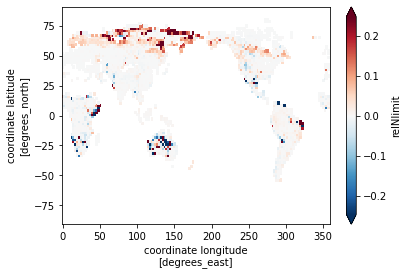

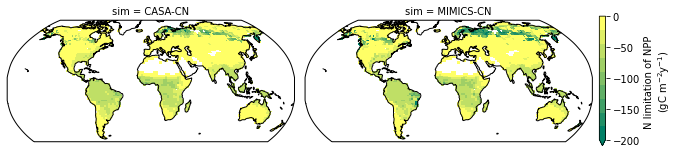

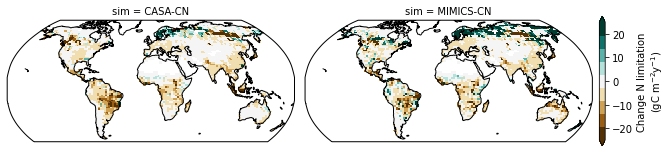

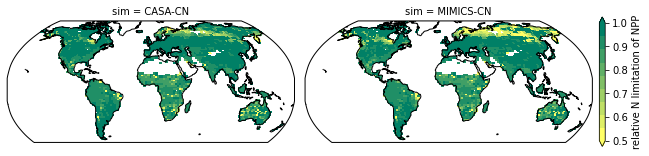

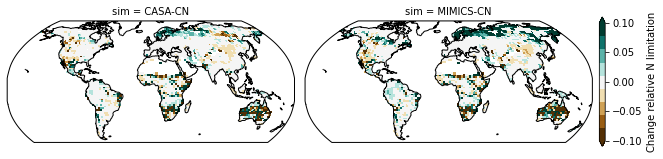

In [67]:
from matplotlib import cm
ds['Nlimit'] = ds['cnpp'] - ds['cnpp'].isel(sim=0) 
ds['Nlimit'].attrs['long_name'] = 'N limitation of NPP'
ds['Nlimit'].attrs['units'] = ds['cnpp'].attrs['units']
ds['relNlimit'] = ds['cnpp']/ ds['cnpp'].isel(sim=0)

ds['relNlimit'].attrs['long_name'] = 'relative N limitation of NPP'
ds['relNlimit'].attrs['units'] = 'fraction'
temp  = ((ds.isel(time=slice(-20,None)).mean(dim='time') -
          ds.isel(time=slice(0,20)).mean(dim='time')) )

(temp['relNlimit'].isel(sim=3) - temp['relNlimit'].isel(sim=1)).plot(robust=True) 

fg = (ds['Nlimit']*365).isel(sim=CNsim, time=slice(0,20)).mean(dim='time').sel(lat=slice(-58,80)).plot(
    x='lon', y='lat',col='sim',col_wrap=2, figsize=[10,2.3],
    vmin = -200, vmax=0,
    cmap=cm.get_cmap('summer', 9),
    cbar_kwargs={
        #"orientation": "horizontal",
        "label": 'N limitation of NPP\n'+r'(gC $\mathregular{m^{-2} y^{-1}}$)',
        "pad": 0.01,
    },
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.Robinson(),
    },
) ;
fg.map(lambda: plt.gca().coastlines())


# look at spatial maps of changes in N limitation 1995:2014 mean - 1901:1920 mean
fg = (temp['Nlimit']*365).isel(sim=CNsim).sel(lat=slice(-58,80)).plot(
    x='lon', y='lat',col='sim',col_wrap=2, figsize=[10,2.3],
    vmin = -25, vmax=25,    
    cmap=cm.get_cmap('BrBG', 9),
    cbar_kwargs={
        #"orientation": "horizontal",
        "label": 'Change N limitation\n'+r'(gC $\mathregular{m^{-2} y^{-1}}$)',
        "pad": 0.01,
    },
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.Robinson(),
    },
) ;
fg.map(lambda: plt.gca().coastlines())
fg.set_titles() ;

# --- look at relative changes too
print('relative changes')

fg = (ds['relNlimit']).isel(time=slice(0,20),sim=CNsim).mean('time').sel(lat=slice(-58,80)).plot(
    x='lon', y='lat',col='sim',col_wrap=2, figsize=[10,2.3],
    vmin = 0.5, vmax=1.,
    cmap=cm.get_cmap('summer_r', 9),
    cbar_kwargs={
        #"orientation": "horizontal",
        "label": 'relative N limitation of NPP',
        "pad": 0.01,
    },
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.Robinson(),
    },
) ;
fg.map(lambda: plt.gca().coastlines())

# look at spatial maps of changes in N limitation 1995:2014 mean - 1901:1920 mean
fg = (temp['relNlimit']).isel(sim=CNsim).sel(lat=slice(-58,80)).plot(
    x='lon', y='lat',col='sim',col_wrap=2, figsize=[10,2.3],
    vmin = -0.1, vmax=0.1,    
    cmap=cm.get_cmap('BrBG', 9),
    cbar_kwargs={
        #"orientation": "horizontal",
        "label": 'Change relative N limitation',
        "pad": 0.01,
    },
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.Robinson(),
    },
) ;
fg.map(lambda: plt.gca().coastlines())
fg.set_titles() ;




### Changes in high latitude N limitation for each model look pretty different, 
reflecting cTOT losses & increases in N mineralizatiton rates


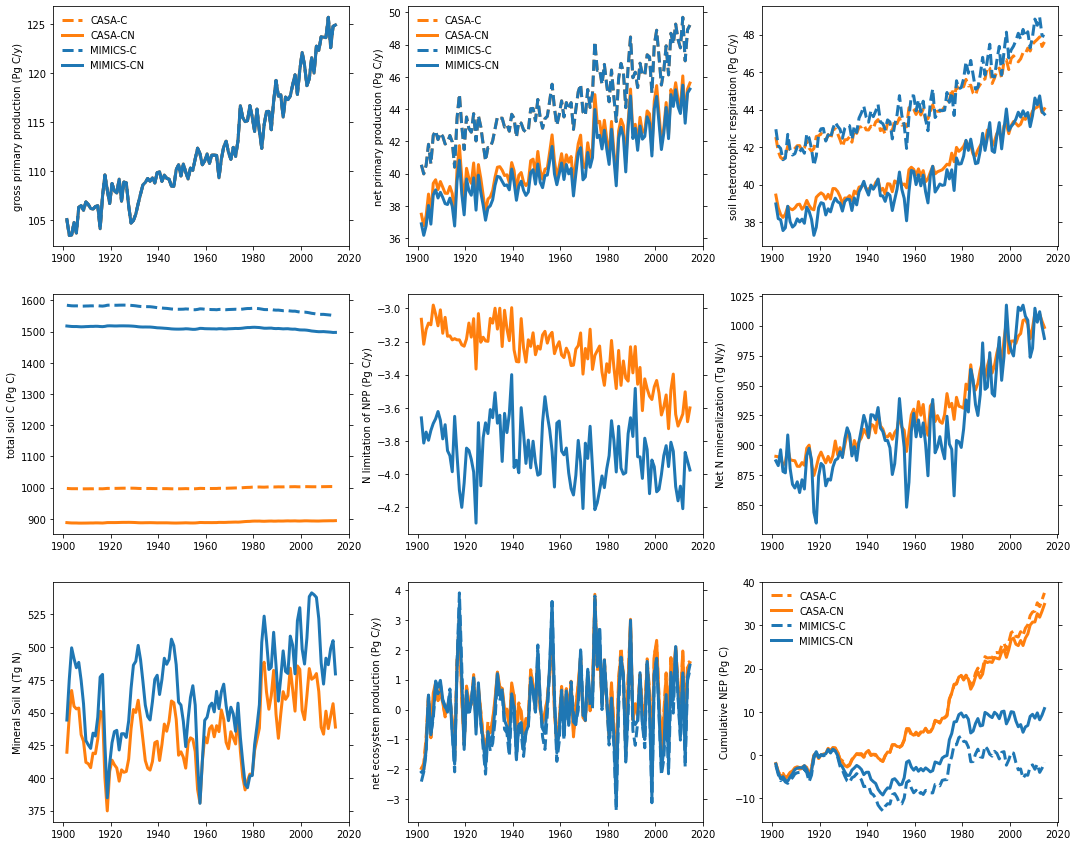

In [68]:
model = simLabs
var = ['cgpp','cnpp','cresp','cTOT','Nlimit',
       'nNetMineralization','nMineral','NEP']
nvar  = len(var)
timeC = [365,365,365,1,365,
         365,1,365]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-15,
              1e-12,1e-12,1e-15]
units = ['(Pg C/y)','(Pg C/y)','(Pg C/y)','(Pg C)','(Pg C/y)',
         '(Tg N/y)','(Tg N)','(Pg C/y)']

fig = plt.figure(figsize=[18,15])
        
for i in range(nvar):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel(ds[var[i]].attrs['long_name']+' '+units[i])
    for j in range(len(model)):
        temp = globalSum(ds[var[i]].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
        ## zero out N fluxes for C-only runs
        if j == 2 or j == 0:
            if i == 4 or i == 5 or i == 6 :
                temp = temp*np.nan
        ax.plot(ds.time, temp, lw=3,color=color[j],linestyle=linestyle[j])     
    #add Hashimoto observations to plot?
    if i==2:
        y = (((HR_out* ds.landarea.isel(sim=2)* 1e6).sum(['lat','lon'])) * 1e-15)
        x = ds.isel(time=slice(0,len(y.time))).time        
        #ax.plot(x, y, lw=3,color='k')     

    if i<2:
        ax.legend(labels=model, frameon = False, fontsize='medium')

ax = fig.add_subplot(3, 3, 9)
i = 7  
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Cumulative '+var[i]+' (Pg C)')
for j in range(len(model)):
    ax.plot(ds.time, np.cumsum(globalSum(ds[var[i]].isel(sim=j),
                               timeC=timeC[i],conversion=conversion[i])), 
            lw=3,color=color[j],linestyle=linestyle[j])        
ax.legend(labels=model, frameon = False, fontsize='medium');

**Figure X** trends in ecosystem C & N fluxes and pools over the historical period simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**
- Both N models have a higher cumulative NEP, but changes w/ MIMICS-CN are greater.
- Implies longer MRT of soil C pools in CN models, relative to their C-only counterparts 
- **OR** larger increases in NPP from regions experiencing N limitation (relative to the C only model). 
- From change time series below, seems like the biggest differences are in HR (not NPP)

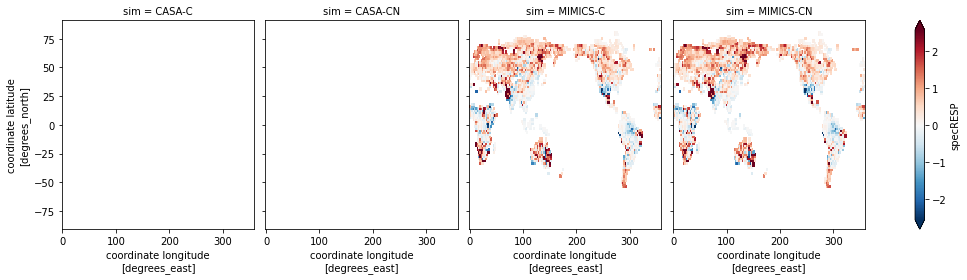

In [69]:
d_specRESP = ds.specRESP.isel(time=slice(-5,None)).mean('time')- \
             ds.specRESP.isel(time=slice( 0,5   )).mean('time')
d_specRESP.plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim);

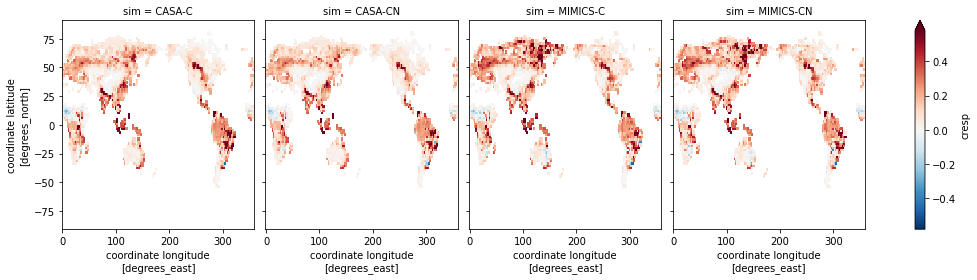

In [70]:
d_HR = ds.cresp.isel(time=slice(-5,None)).mean('time') - \
       ds.cresp.isel(time=slice( 0,5   )).mean('time')
d_HR.plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim);

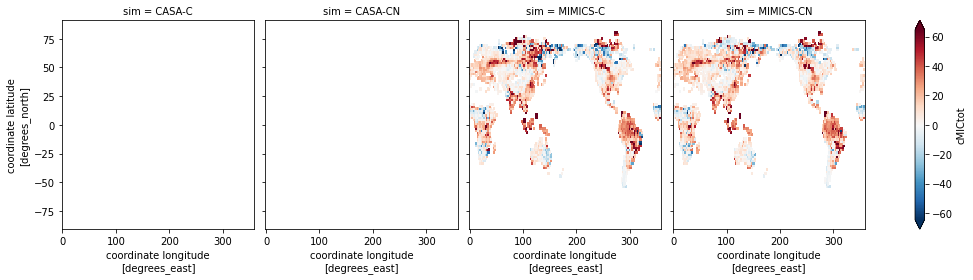

In [71]:
d_cMICtot = ds.cMICtot.isel(time=slice(-5,None)).mean('time')- \
            ds.cMICtot.isel(time=slice(0,5)).mean('time')
d_cMICtot.plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim);

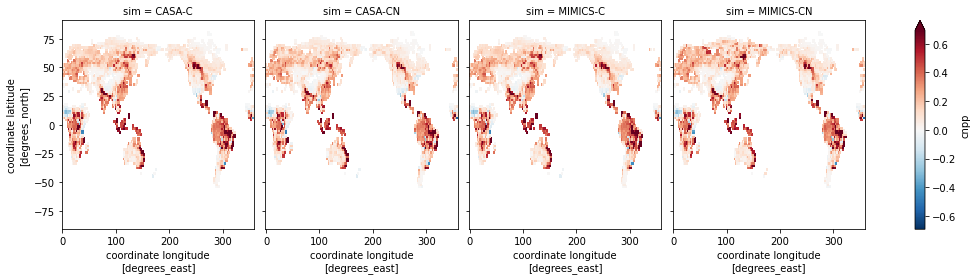

In [72]:
testVar = 'cnpp'
d_test = ds[testVar].isel(time=slice(-5,None)).mean('time') - \
         ds[testVar].isel(time=slice(0,5)).mean('time')
d_test.plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim);

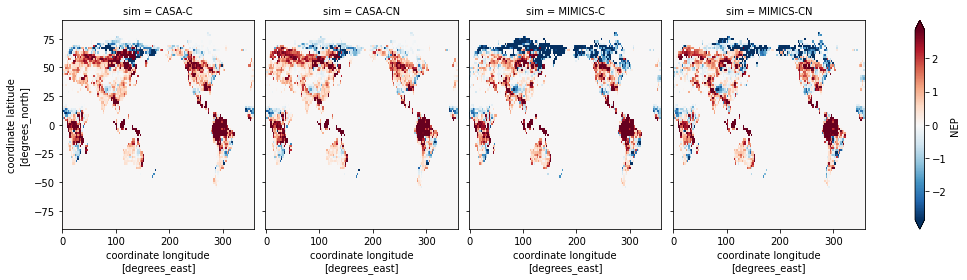

In [73]:
cumNEP = ds['NEP'].cumsum(dim='time').isel(time=-1)
cumNEP.plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim);


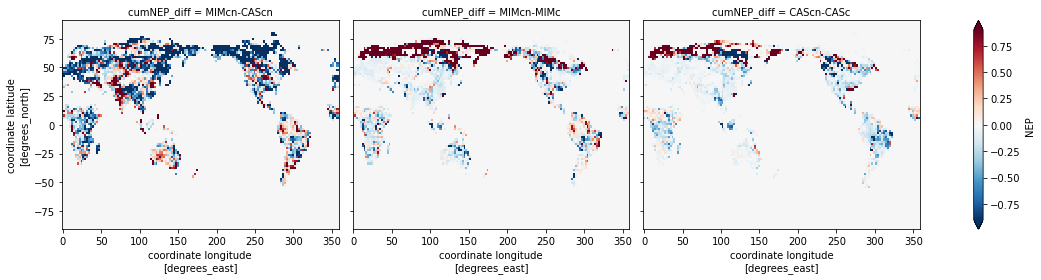

In [74]:
#Differences in NEP CN-Conly
MIMcn_CAScn  = cumNEP.isel(sim=3)-cumNEP.isel(sim=1)
MIMcn_MIMc   = cumNEP.isel(sim=3)-cumNEP.isel(sim=2)
CAScn_CASc   = cumNEP.isel(sim=1)-cumNEP.isel(sim=0)

cn_c = xr.concat([MIMcn_CAScn,MIMcn_MIMc,CAScn_CASc], 'cumNEP_diff')
cn_c['cumNEP_diff'] = ['MIMcn-CAScn','MIMcn-MIMc','CAScn-CASc']

g_simple = cn_c.plot(x="lon", y="lat", col="cumNEP_diff", robust=True,
                                   col_wrap=3,figsize=[16,4],cmap="RdBu_r")


**Figure y** N effects on cumulative NEP (1901-2014) 
- MIMICS with less net land uptake than CASA (left) 
- Biggest differences in cumulative NEP in MIMICS across arctic and boreal forests (middle), 
- CASA effects of N limitation on cumulative land C uptake are weaker (right) 

Are changes  really just reflecting the degree of initial N limitation in CN models?

# Changes from initial conditions

In [75]:
print(globalSum(ds['NEP'].isel(sim=3), timeC=365,conversion=1e-15).isel(time=slice(0,None)).sum())

<xarray.DataArray ()>
array(10.738064, dtype=float32)
Coordinates:
    sim      <U9 'MIMICS-CN'


 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_6_GlobalChanges.pdf --


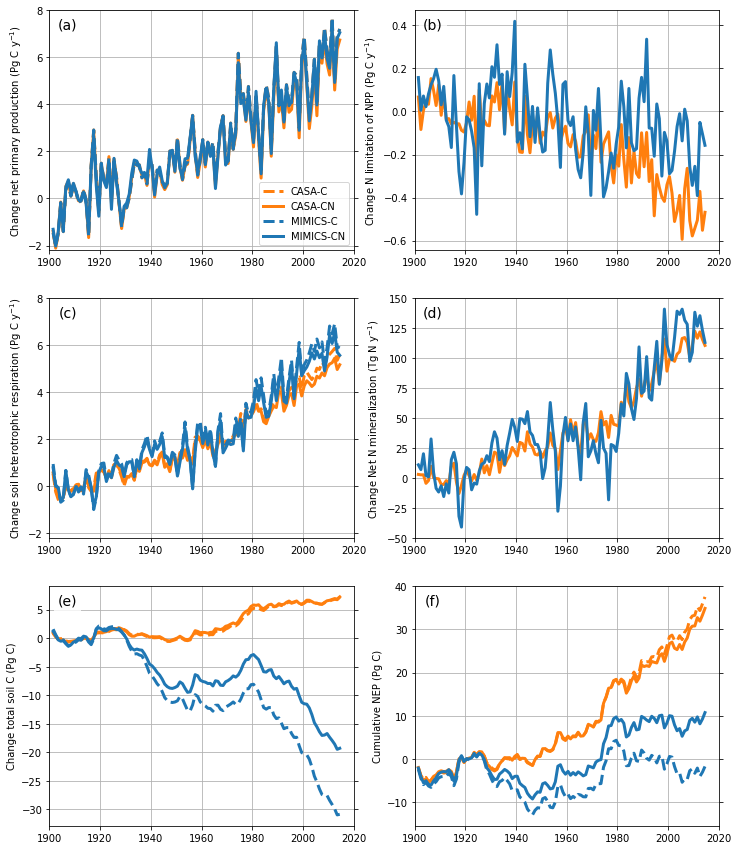

In [76]:
model = simLabs
fig = plt.figure(figsize=[12,15]);
t = 20

var = ['cnpp','Nlimit',
       'cresp','nNetMineralization',
       'cTOT','NEP']
nvar  = len(var)
timeC = [365,365,
         365,365,
         1,365]
conversion = [1e-15,1e-15,
              1e-15,1e-12,
              1e-15,1e-15]
units = [r'(Pg C $\mathregular{y^{-1}}$)',r'(Pg C $\mathregular{y^{-1}}$)',
         r'(Pg C $\mathregular{y^{-1}}$)',r'(Tg N $\mathregular{y^{-1}}$)',
         '(Pg C)','(Pg C)']

for i in range(nvar-1):
    ax = fig.add_subplot(3, 2, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Change '+ds[var[i]].attrs['long_name']+' '+units[i])
    ax.grid() 
    ax.set_xlim(1900, 2020)
    ax.annotate(panel[i], xy=(0.06, 0.94), xycoords=ax.transAxes, 
                ha='center', va='center',fontsize=14,
                bbox=dict(facecolor='white', alpha=0.8,edgecolor='none') )    
    for j in range(len(model)):
        temp = globalSum(ds[var[i]].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
        ## zero out N fluxes for C-only runs
        if j == 2 or j == 0:
            if i == 1 or i == 3:
                temp = temp*np.nan
                
        ax.plot(ds.time, (temp - temp.isel(time=slice(0,t)).mean()), 
                lw=3,color=color[j],linestyle=linestyle[j])        
    if i==0:
        ax.legend(labels=model, frameon = True, fontsize='medium',loc='lower right')
        ax.set_ylim(-2.2, 8)
    if i == 2:
        ax.set_ylim(-2.2, 8)

ax = fig.add_subplot(3, 2, 6)
i = 5  
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Cumulative '+var[i]+' (Pg C)')
ax.set_xlim(1900, 2020)
ax.annotate(panel[i], xy=(0.06, 0.94), xycoords=ax.transAxes, 
            ha='center', va='center',fontsize=14,
            bbox=dict(facecolor='white', alpha=0.8,edgecolor='none'))    
for j in range(nsim):
    ax.plot(ds.time, np.cumsum(globalSum(ds[var[i]].isel(sim=j),
                               timeC=timeC[i],conversion=conversion[i])), 
            lw=3,color=color[j],linestyle=linestyle[j])        
#ax.legend(labels=model, frameon = False, fontsize='medium')
ax.grid()  ;

if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_6_GlobalChanges.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;
    
    

**Figure 6** Changes in ecosystem C & N fluxes and pools, relative to initial conditions, over the historical period 
simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only 
configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**
- Does this influence N limitation in regions where SOM turnover is accelerating?
- Greater IAV of C&N fluxes from MIMICS, it would be interesting to see the source & driver of this variability (temp, moisture, productivity).

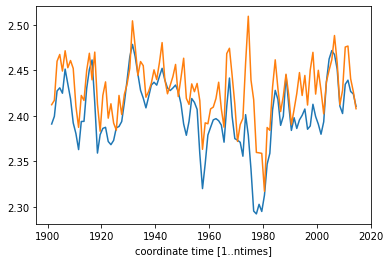

In [77]:
# Calculate N mineralzation as a function of HR
ds['npc'] = ds['nNetMineralization']/ds['cresp'] * 1000
globalSum(ds['npc'].isel(sim=3)).plot()
globalSum(ds['npc'].isel(sim=1)).plot()
ds['npc'].attrs['units'] = 'mg N mineralized per g C respired'


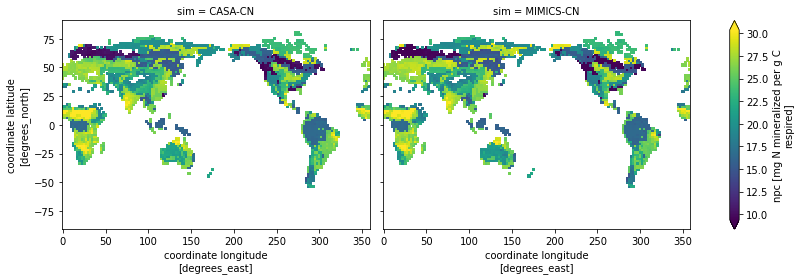

In [78]:
npc = ds['npc'].isel(time=slice(0,20)).mean('time').isel(sim=[1,3]) 
npc.attrs['units'] = 'mg N mineralized per g C respired'

g_simple = npc.plot(x="lon", y="lat", col='sim', robust=True,col_wrap=2,figsize=[12,4])

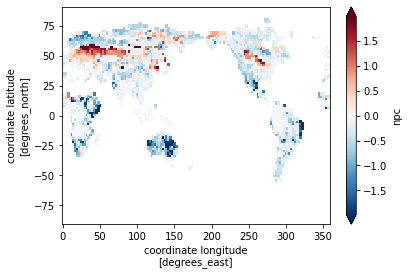

In [79]:
(npc.isel(sim=1) - npc.isel(sim=0)).plot(robust=True) ;
#MIMICS-CASA

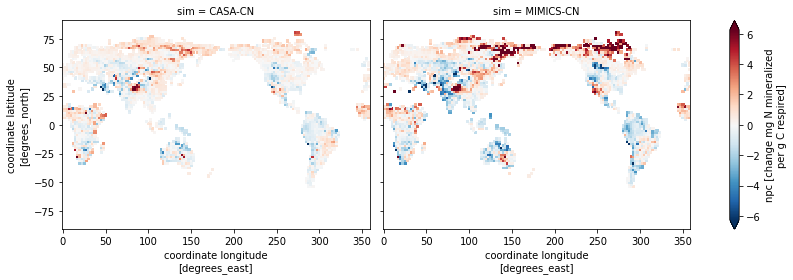

In [80]:
npc2 = ds['npc'].isel(time=slice(-20,None)).mean('time').isel(sim=[1,3]) - npc
npc2.attrs['units'] = 'change mg N mineralized per g C respired'

g_simple = npc2.plot(x="lon", y="lat", col='sim', robust=True,col_wrap=2,figsize=[12,4])

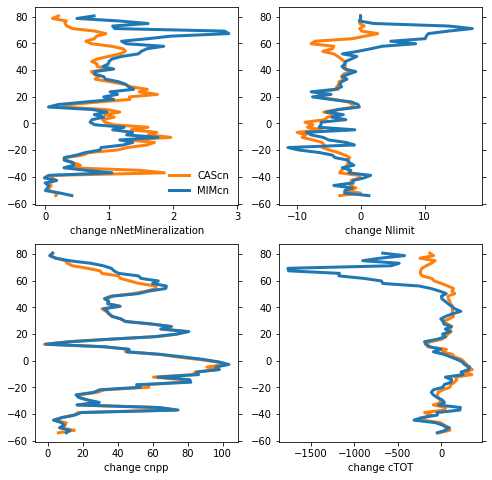

In [81]:
# look at zonal mean of changes in N limitation 1995:2014 mean - 1901:1920 mean
temp  = ((ds.isel(time=slice(-20,None)).mean(dim='time') -
          ds.isel(time=slice(0,20)).mean(dim='time')) )

plotVar = ['nNetMineralization','Nlimit','cnpp','cTOT']
#dHist.mean(dim='lon').isel(deltaHist=i)
fig = plt.figure(figsize=[8,8]);
t = 20
model = ['CAScn','MIMcn'] 
for i in range(len(plotVar)):
    ax = fig.add_subplot(2, 2, (i+1))
    for j in CNsim:  #loop over simulations
        x = temp[plotVar[i]].mean(dim='lon').isel(sim=j)
        #convert daily to annual flux
        if i < 3: x = x*365
        ax.plot(x, temp.lat, 
                lw=3,color=color[j],linestyle=linestyle[j])
    ax.set_xlabel("change "+plotVar[i])
    ax.yaxis.set_ticks_position('both')
    if i==0:
        ax.legend(labels=model, frameon = False, fontsize='medium')


gC m-2 day-1


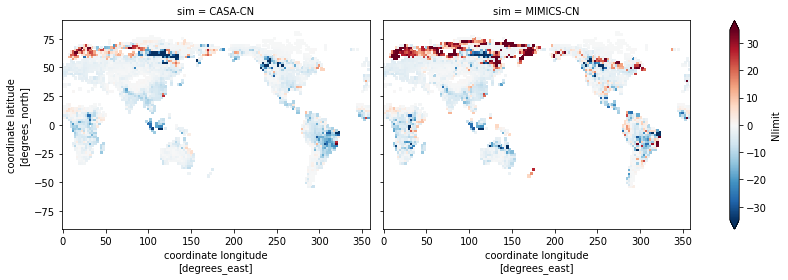

In [82]:
plotVar = 'Nlimit'
g_simple = (365*(ds[plotVar].isel(time=slice(-20,None)).mean('time').isel(sim=[1,3]) - \
            ds[plotVar].isel(time=slice(0,20)).mean('time').isel(sim=[1,3])) \
           ).plot(x="lon", y="lat", col='sim', robust=True,col_wrap=2,figsize=[12,4])
print(ds[plotVar].attrs['units'])

gC m-2


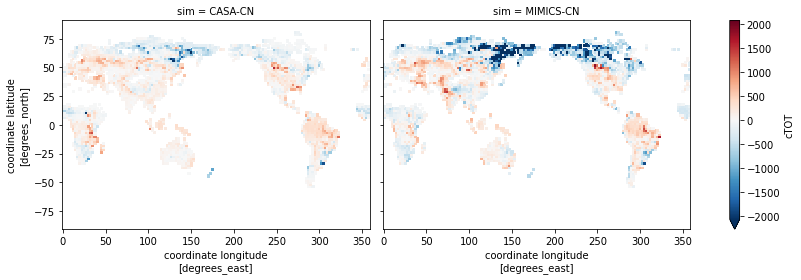

In [83]:
plotVar = 'cTOT'

g_simple = ((ds[plotVar].isel(time=slice(-20,None)).mean('time').isel(sim=[1,3]) - \
            ds[plotVar].isel(time=slice(0,20)).mean('time').isel(sim=[1,3])) \
           ).plot(x="lon", y="lat", col='sim', robust=True,col_wrap=2,figsize=[12,4])
print(ds[plotVar].attrs['units'])

### changes in total pools

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_X_Cchanges_HIST.pdf --


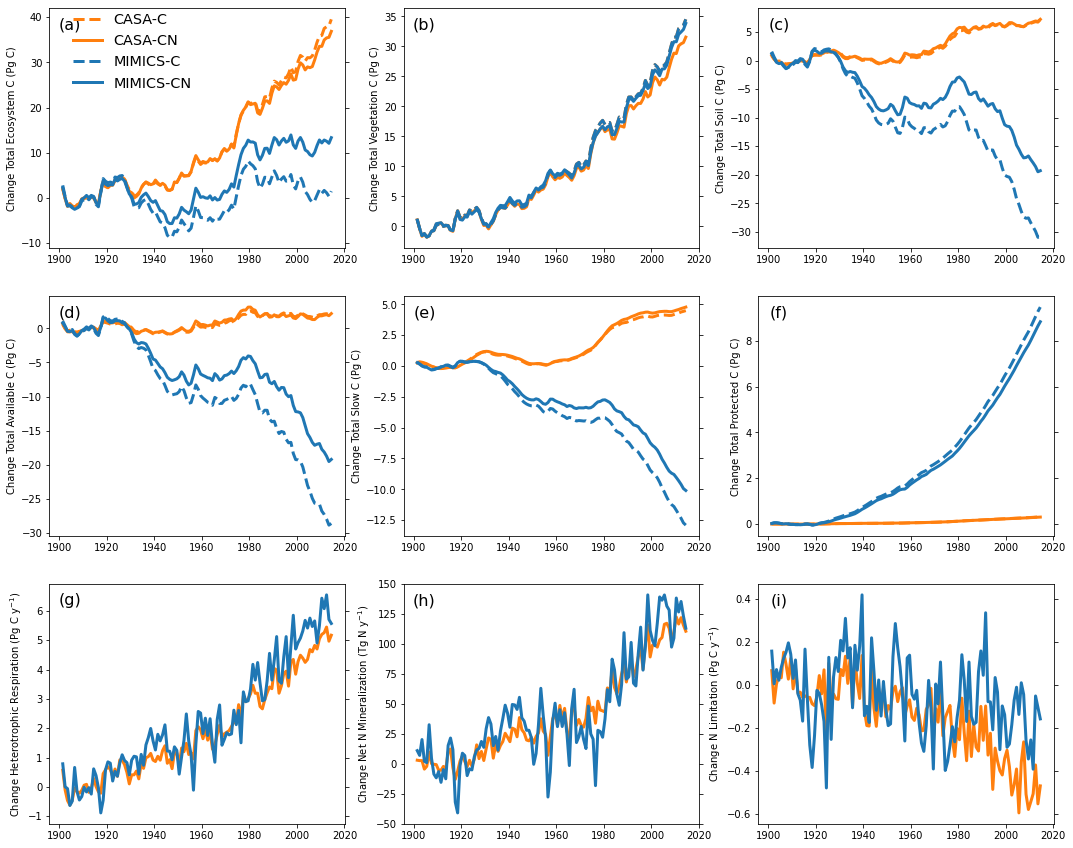

In [84]:
var = ['cECO','cVEG','cTOT','cAVAIL','cSOMc','cSOMp',
       'cresp','nNetMineralization','Nlimit']
ylab = ['Total Ecosystem C','Total Vegetation C','Total Soil C',
        'Total Available C','Total Slow C','Total Protected C',
        'Heterotrophic Respiration','Net N Mineralization','N Limitation']
timeC = [1,1,1,1,1,1,365,365,365]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-12,1e-15]
units = ['(Pg C)','(Pg C)','(Pg C)','(Pg C)','(Pg C)','(Pg C)',
         '(Pg C $\mathregular{y^{-1}}$)',
         '(Tg N $\mathregular{y^{-1}}$)','(Pg C $\mathregular{y^{-1}}$)']
model = simLabs

fig = plt.figure(figsize=[18,15]);

# loop over variables 
for i in range(len(var)):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Change '+ylab[i]+' '+units[i])
    ax.annotate(panel[i], xy=(0.07, 0.93), xycoords=ax.transAxes, 
                ha='center', va='center',fontsize=16)    

    # loop over simulations
    for j in range(nsim):  
        if var[i] == 'cAVAIL':
            if j < 2:
                temp = globalSum((ds['clitmetb']+ds['clitstr']+ds['csoilmic']).isel(
                    sim=j),timeC=timeC[i],conversion=conversion[i])
            else: 
                temp = globalSum((ds['cLITm']+ds['cLITs']+ds['cSOMa']).isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
                            
        else:
            temp = globalSum(ds[var[i]].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
        ## changes in passive pool for CASA-only runs
        if j < 2 :
            if i == 4:
                temp = globalSum(ds['csoilslow'].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
            if i == 5:
                temp = globalSum(ds['csoilpass'].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
                
        if i < 6:
            ax.plot(ds.time, (temp - temp.isel(time=slice(0,t)).mean()), 
                    lw=3,color=color[j],linestyle=linestyle[j]) 
        else: #Skip N variables for C only models
            if j == 1 or j == 3:
                ax.plot(ds.time, (temp - temp.isel(time=slice(0,t)).mean()), 
                        lw=3,color=color[j],linestyle=linestyle[j]) 
            
    if i==0:
        ax.legend(labels=model, frameon = False, bbox_to_anchor=[0.28, 0.82],
                  loc='center',fontsize='x-large')

fout = fin[0]+'figs/'+sim[0]+'_Fig_X_Cchanges_HIST.pdf'
plt.savefig(fout)
print(' -- wrote '+fout+' --')  

**Fig X** Changes in total ecosystem, Veg, and SOM pools (top row), 
Changes in available, slow, and passive C.  
- It's potentially useful to look at changes and IAV of Nmineralization and Nlimitation, but maybe that's better in another figure or with daily data?

In [85]:
# ratio of respiration:mineralization over time
var = ['cresp','nNetMineralization']
ds['HR:Min'] = (ds[var[0]]/ds[var[1]])

In [86]:
# Zonal mean of changes by end of simulation
dsZon = (ds - ds.isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')

## plot zonal mean over time

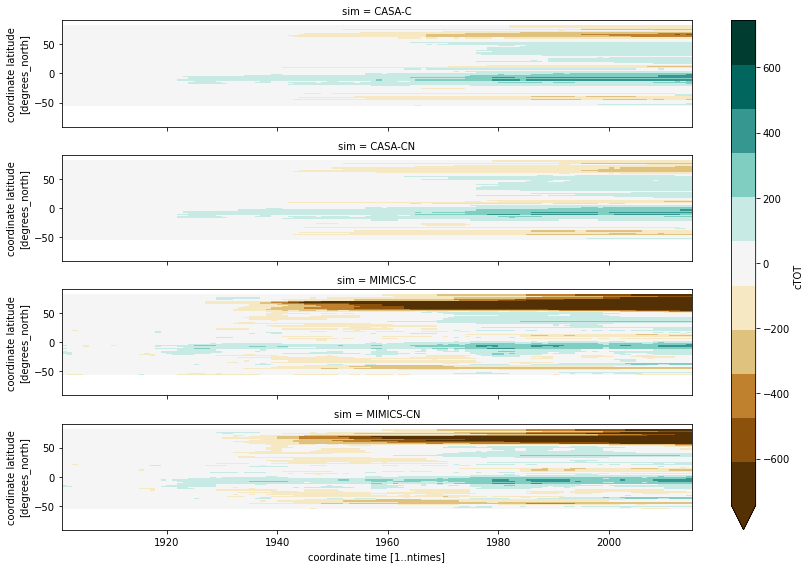

In [87]:
from matplotlib import cm

dsZon['cTOT'].plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[12,8],col_wrap=1, 
                   cmap=cm.get_cmap('BrBG', 11) ) ; 

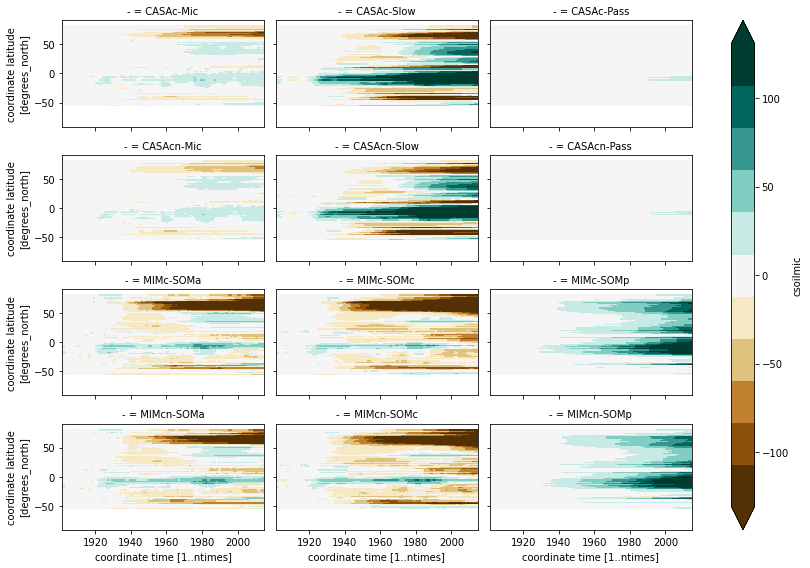

In [88]:
temp = xr.concat([dsZon.isel(sim=0)['csoilmic'],dsZon.isel(sim=0)['csoilslow'], dsZon.isel(sim=0)['csoilpass'],
                  dsZon.isel(sim=1)['csoilmic'],dsZon.isel(sim=1)['csoilslow'], dsZon.isel(sim=1)['csoilpass'],
                  dsZon.isel(sim=2)['cSOMa'],   dsZon.isel(sim=2)['cSOMc'], dsZon.isel(sim=2)['cSOMp'],
                  dsZon.isel(sim=3)['cSOMa'],   dsZon.isel(sim=3)['cSOMc'], dsZon.isel(sim=3)['cSOMp']],
                 '-')
temp['-'] = ['CASAc-Mic' ,'CASAc-Slow' ,'CASAc-Pass',
             'CASAcn-Mic','CASAcn-Slow','CASAcn-Pass',
             'MIMc-SOMa' ,'MIMc-SOMc' ,'MIMc-SOMp' ,
             'MIMcn-SOMa','MIMcn-SOMc' ,'MIMcn-SOMp']                 
temp.plot(
    x="time", y="lat", col="-", robust=True,figsize=[12,8],col_wrap=3,
    cmap=cm.get_cmap('BrBG', 11) ) ; 

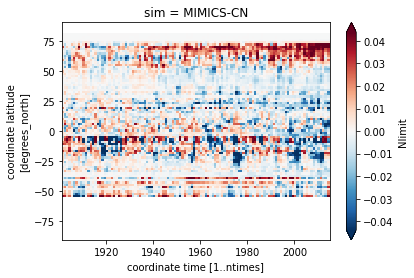

In [89]:
dsZon.Nlimit.isel(sim=3).plot(robust=True)

### Plot maps of where fluxes are changing

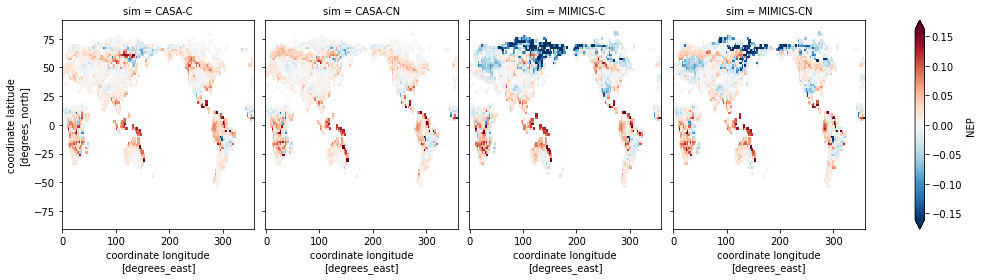

In [90]:
var='NEP'
(ds[var].isel(time=slice(-20,None)).mean(dim='time')-
 ds[var].isel(time=slice(  0,20  )).mean(dim='time')).plot(
    x="lon",y="lat",col="sim",robust=True,figsize=[15,4],
    col_wrap=nsim);

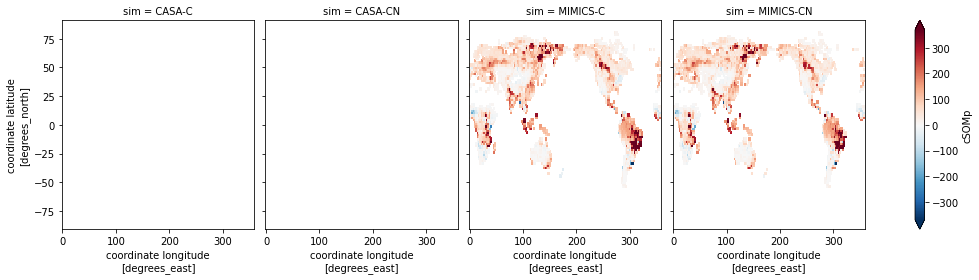

In [91]:
var = ['cresp','tsoilC','nNetMineralization','cSOMp','cTOT','fW']
tempMIM = (ds[var[3]].isel(time=slice(-10,None)).mean(dim='time')-
           ds[var[3]].isel(time=slice(  0,10  )).mean(dim='time'))
tempMIM.plot(x="lon",y="lat",col="sim",robust=True,figsize=[15,4],
    col_wrap=nsim) ;

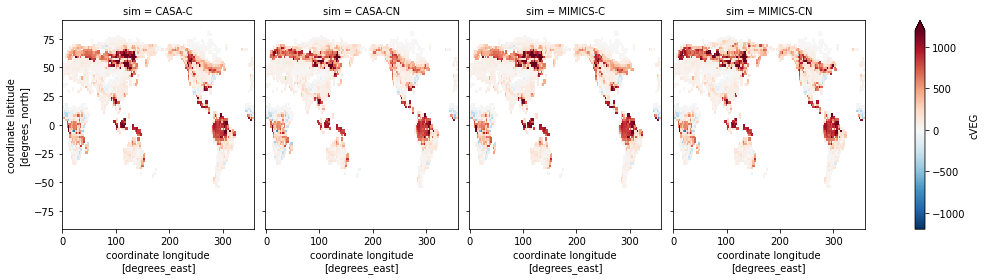

In [92]:
var = ['cresp','tsoilC','nNetMineralization','csoilpass','cTOT','fW','cVEG']
tempCAS = (ds[var[6]].isel(time=slice(-20,None)).mean(dim='time')-
           ds[var[6]].isel(time=slice(  0,20  )).mean(dim='time'))
tempCAS.plot(x="lon",y="lat",col="sim",robust=True,figsize=[15,4],
    col_wrap=nsim) ;

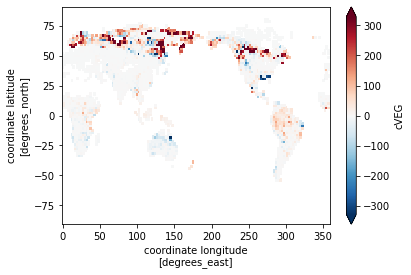

In [93]:
# delta delta plots
# difference of difference plots: mimics CN- casa CN
(tempCAS.isel(sim=3) - tempCAS.isel(sim=1)).plot(robust=True) ; 

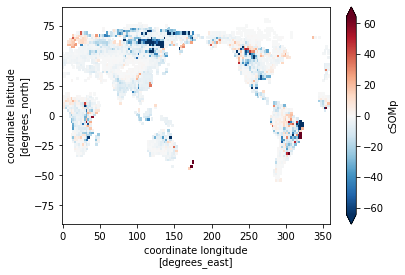

In [94]:
(tempMIM.isel(sim=3) - tempMIM.isel(sim=2)).plot(robust=True);
# not sure what a meaningful way to look at these changes may be?

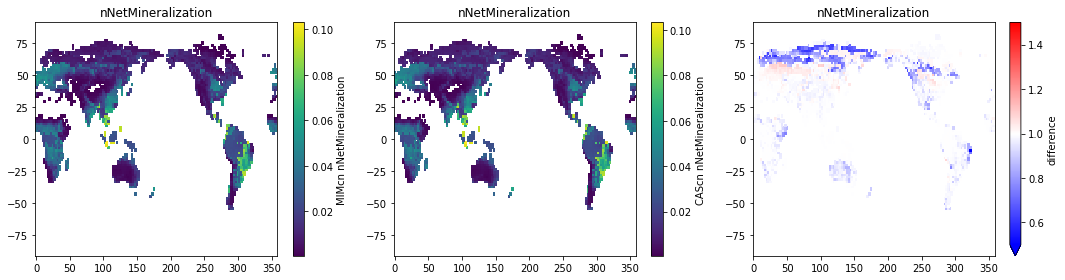

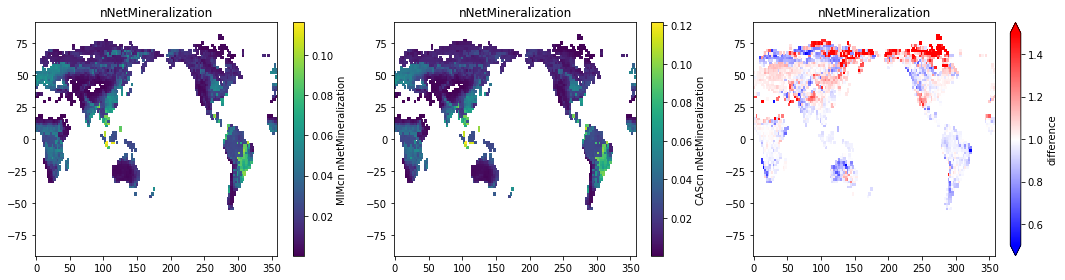

In [95]:

ncols = 3
nrows = 1
#  lists of variables, titles & labels
plotVars = ['nNetMineralization']
#plotVars = ['cnTOT']
plotTitle = plotVars
plotLable = plotVars

# create the plots
fig = plt.figure(figsize=(15,4))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c) for r in range(0, nrows) for c in range(0, ncols) ]

# add some data
i = 0
j=0            
for ax in axes:
    if i == 0:
        ds[plotVars[j]].isel(time=slice(0,20),sim=3).mean('time').plot(
            ax=ax, cbar_kwargs={'label': 'MIMcn '+plotLable[j]} )
    if i == 1:
        ds[plotVars[j]].isel(time=slice(0,20),sim=1).mean('time').plot(
            ax=ax,  cbar_kwargs={'label': 'CAScn '+plotLable[j]} )
    if i == 2:
        nMIN1 = (ds[plotVars[j]].isel(time=slice(0,20),sim=3).mean('time')/  \
                 ds[plotVars[j]].isel(time=slice(0,20),sim=1).mean('time') )
        nMIN1.plot(ax=ax, vmax=1.5,vmin=0.5, cbar_kwargs={'label': 'difference'},cmap='bwr')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(plotTitle[j])
    i = i+1

plt.tight_layout()


# create the plots
fig = plt.figure(figsize=(15,4))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c) for r in range(0, nrows) for c in range(0, ncols) ]

# add some data
i = 0
j=0            
for ax in axes:
    if i == 0:
        ds[plotVars[j]].isel(time=slice(-20,None),sim=3).mean('time').plot(
            ax=ax, cbar_kwargs={'label': 'MIMcn '+plotLable[j]})
    if i == 1:
        ds[plotVars[j]].isel(time=slice(-20,None),sim=1).mean('time').plot(
            ax=ax,  cbar_kwargs={'label': 'CAScn '+plotLable[j]})
    if i == 2:
        nMIN2 = (ds[plotVars[j]].isel(time=slice(-20,None),sim=3).mean('time')/  \
                 ds[plotVars[j]].isel(time=slice(-20,None),sim=1).mean('time') )
        nMIN2.plot(ax=ax, vmax=1.5,vmin=0.5, cbar_kwargs={'label': 'difference'},cmap='bwr')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(plotTitle[j])
    i = i+1

plt.tight_layout()


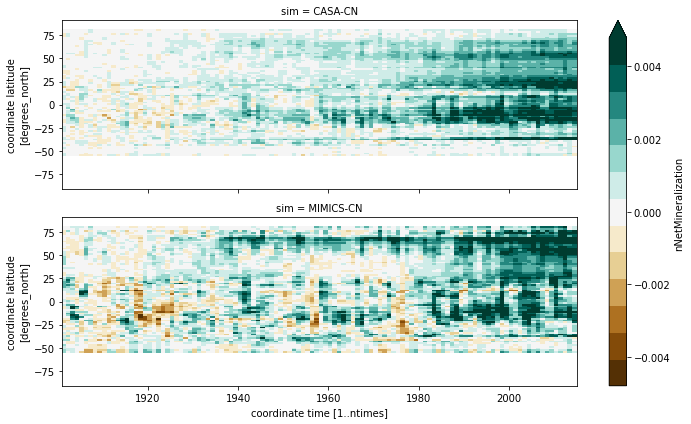

In [96]:
#changes in mineralization over time in both models
var2 = ['cnpp','cresp','NEP','cTOT','nNetMineralization','HR:Min','cnTOT']

dsZon[var2[4]].isel(sim=CNsim).plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[10,6],col_wrap=1, 
                   cmap=cm.get_cmap('BrBG', 13) ) ;  


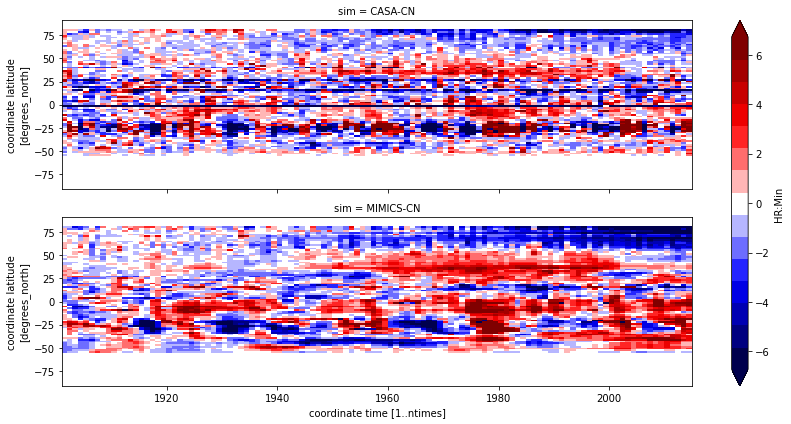

In [97]:
# Basically show the C:N of microbial spilling
dsZon['HR:Min'].isel(sim=CNsim).plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[12,6],col_wrap=1, 
                   cmap=cm.get_cmap('seismic', 15) ) ; 

**Figure X.** Zonal mean changes in N mineralization rates simulated by MIMICS-cn & CASA-cn


### Zonal mean changes, relative to C-only model

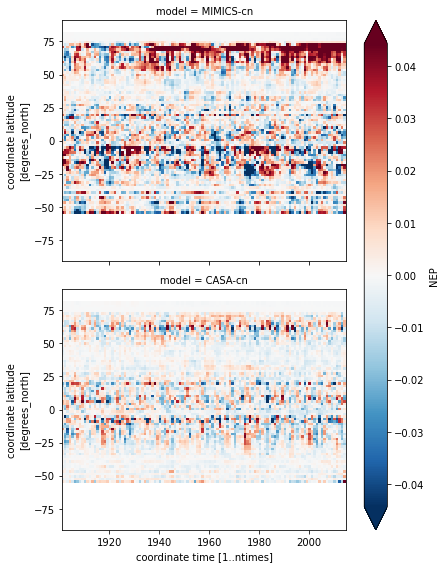

In [98]:
#changes, relative to the C-only model
var2 = ['cnpp','cresp','NEP','cTOT']
ds2 = ds[var2].copy('deep')

dMIMcn = ((ds2.isel(sim=3)-ds2.isel(sim=(3-1)))).mean(dim='lon')
dCAScn = ((ds2.isel(sim=1)-ds2.isel(sim=(1-1)))).mean(dim='lon') 

model = xr.DataArray(['MIMICS-cn','CASA-cn'], dims='model', name='model') # or can use np.arange
t = xr.concat([dMIMcn,dCAScn],dim=model)

#t = t-t.isel(time=slice(0,20)).mean(dim='time')
simple = t[var2[2]].plot(x='time', y='lat',col='model',col_wrap=1, figsize=[6,8],robust=True);#vmax=5e-3,vmin=-5e-3);



**Figure X.** Zonal mean changes in rates simulated by MIMICS-cn 

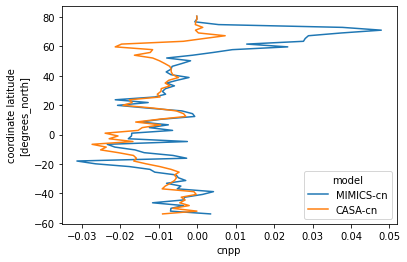

In [99]:
## Change in N limitation ove time
(t[var2[0]].isel(time=slice(-20,None)).mean('time')- \
 t[var2[0]].isel(time=slice(  0,20  )).mean('time')).plot(y='lat',hue='model') ;

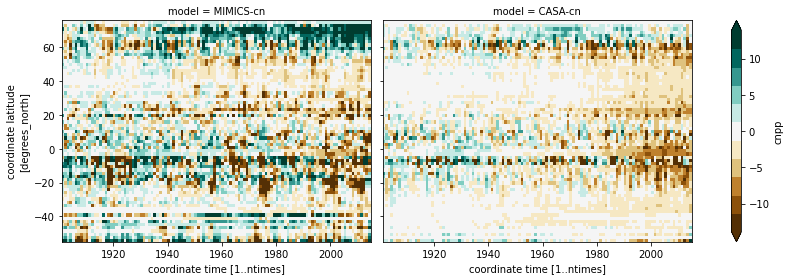

In [100]:
v=0
d_t = (t - t.isel(time=slice(0,20)).mean('time'))
d_t['cnpp'].attrs['long_name'] = 'Change in N limitation of NPP'
#d_t['cnpp'] = d_t['cnpp'] * -1 

simple = (d_t[var2[v]]*365).sel(lat=slice(-55,75)).plot(
    x='time', y='lat',col='model',col_wrap=2, 
    figsize=[12,4],robust=True, cmap=cm.get_cmap('BrBG', 11))

# N limtitation data are pretty noisy, especially for MIMICS
## try rolling mean to smooth our resutls and see clearer trends


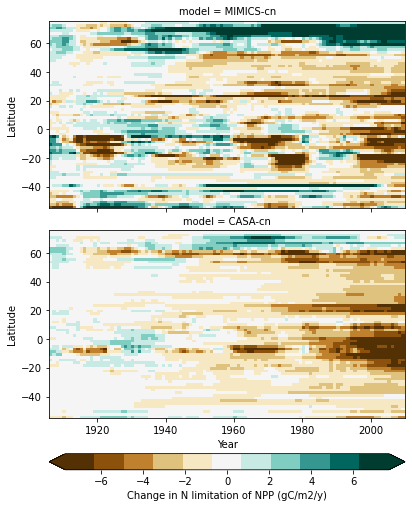

In [101]:
v=0
fg = ((d_t[var2[v]]*365).rolling(
    time=10, center=True).mean()).sel(
    lat=slice(-55,75),time=slice(1906,2010)).plot(
    x='time', y='lat',col='model',col_wrap=1, figsize=[6,8],robust=True,
    cmap=cm.get_cmap('BrBG', 11),
    cbar_kwargs={
        "orientation": "horizontal",
        "label": d_t[var2[v]].attrs['long_name']+' (gC/m2/y)',
        "pad": 0.07}
)
fg.set_xlabels('Year')
fg.set_ylabels('Latitude') ;


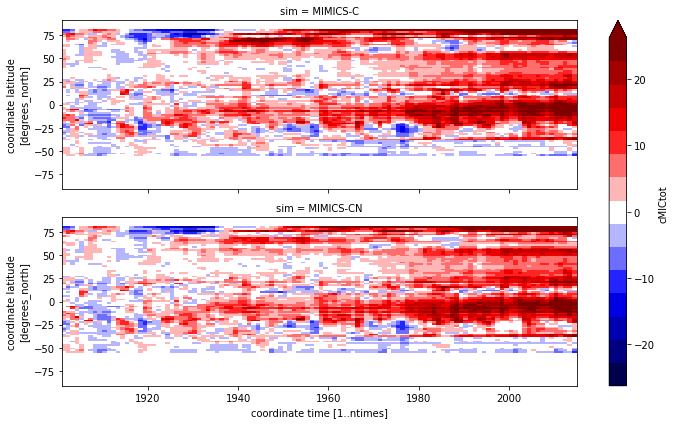

In [102]:
# Mimics specifics rsults
# var = ['specRESP','cMICtot','MICrK','cnMIC']
dsZon['cMICtot'].isel(sim=MIMsim).plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[10,6],col_wrap=1, 
                   cmap=cm.get_cmap('seismic', 15) ) ; 

---
## Daily data
this should likely be for a longer time period

In [103]:
ds

<xarray.Dataset>
Dimensions:              (lat: 96, lon: 144, sim: 4, time: 114)
Coordinates:
  * sim                  (sim) object 'CASA-C' 'CASA-CN' 'MIMICS-C' 'MIMICS-CN'
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
  * time                 (time) float32 1901.5013 1902.5013 ... 2014.5013
Data variables:
    day                  (sim, time, lat, lon) float64 nan nan nan ... nan nan
    IGBP_PFT             (sim, lat, lon) float64 nan nan nan nan ... nan nan nan
    landarea             (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cellMissing          (sim, lat, lon) float64 nan nan nan nan ... nan nan nan
    cellid               (sim, lat, lon) float64 nan nan nan nan ... nan nan nan
    cLITm                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cLITs                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cMICr                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cMICk                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMa                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMc                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMp                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cHresp               (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMpIn              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cLitInput_metb       (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cLitInput_struc      (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cOverflow_r          (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cOverflow_k          (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLITm                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLITs                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nMICr                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nMICk                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nSOMa                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nSOMc                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nSOMp                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    DIN                  (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLitInput_metb       (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLitInput_struc      (sim, lat, lon, time) float32 nan nan nan ... nan nan
    thetaLiq             (sim, lat, lon, time) float32 nan nan nan ... nan nan
    thetaFrzn            (sim, lat, lon, time) float32 nan nan nan ... nan nan
    fW                   (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cresp                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cnpp                 (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cgpp                 (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cleaf                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nleaf                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cwood                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nwood                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cfroot               (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nfroot               (sim, lat, lon, time) float32 nan nan nan ... nan nan
    clitmetb             (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nlitmetb             (sim, lat, lon, time) float32 nan nan nan ... nan nan
    clitstr              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nlitstr              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    clitcwd              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nlitcwd            

---
## Look at environmental controls over soil C:N in MIMICS

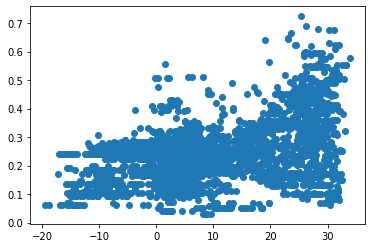

In [104]:
temp = ds.isel(time=slice(0,20), sim=1).mean('time')
plt.scatter(temp.tsoilC,temp.clay)

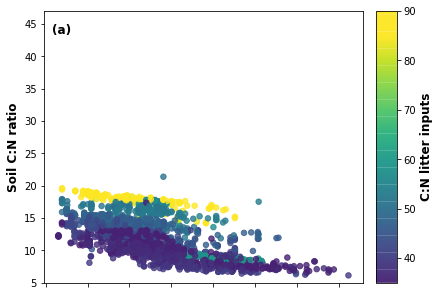

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_5a_soilCN.pdf --


<Figure size 432x288 with 0 Axes>

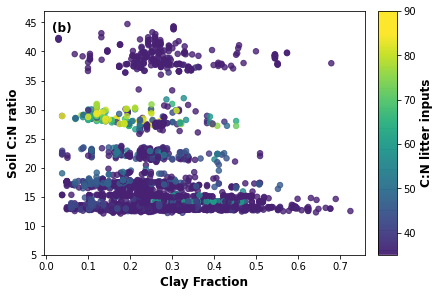

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_5b_soilCN.pdf --


<Figure size 432x288 with 0 Axes>

In [105]:
model = simLabs
sub = ['a','b','c']
j = 0
for i in [3,1]:
    ds_1 = ds.isel(time=slice(0,20), sim=i).mean('time')
    if i == 1:
        ds_1['cnLIT'] = (ds_1.cLitInptMet + ds_1.cLitInptStruc) / \
                         (ds_1.nLitInptMet + ds_1.nLitInptStruc)
    else:
        ds_1['cnLIT'] = (ds_1.cLitInput_metb + ds_1.cLitInput_struc) / \
                         (ds_1.nLitInput_metb + ds_1.nLitInput_struc)
    ds_1['cnLIT'].attrs['long_name'] = 'C:N litter inputs'

    color_by = ds_1['cnLIT'] 
    label = ds_1['cnLIT'].attrs['long_name']
    fig, ax = plt.subplots(constrained_layout=True)
    s = ax.scatter(ds_1.clay, ds_1['cnTOT'],
                   c=color_by,
                   s=30,
                   marker='o',          # Plot circles
                   cmap = utils.truncate_colormap(
                       #cmapIn='Dark2', minval=0.05, maxval=0.84),
                       cmapIn='viridis', minval=0.1, maxval=1,n=12),
                   alpha=0.8,
                   #cmap = cm.get_cmap('viridis', 12),
                   vmin = 35,vmax = 90,
                  )           # Max value

    # Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
    cbar = plt.colorbar(mappable = s, ax = ax)   
    cbar.set_label(label,fontsize='large', fontweight='bold')
    if i == 1:
        plt.xlabel('Clay Fraction',fontsize='large', fontweight='bold')
        plt.text(0.015, 43.5,'(b)',fontsize='large', fontweight='bold')
    else:
        plt.text(0.015, 43.5,'(a)',fontsize='large', fontweight='bold')
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=True,       # ticks along the bottom edge are on
            top=False,         # ticks along the top edge are off
            labelbottom=False) 
        
    plt.ylim((5, 47))
    plt.ylabel('Soil C:N ratio',fontsize='large', fontweight='bold')
    plt.show();
    if save == True:
        fout = fin[0]+'figs/'+sim[0]+'_Fig_5'+sub[j]+'_soilCN.pdf'
        plt.savefig(fout)
        print(' -- wrote '+fout+' --') ;

    j = j+1
    


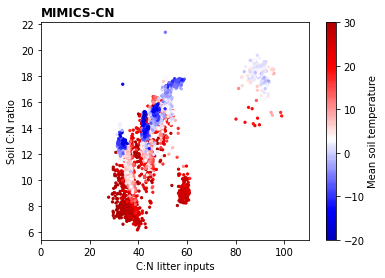

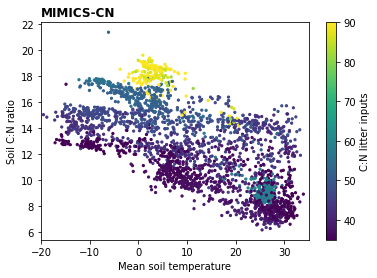

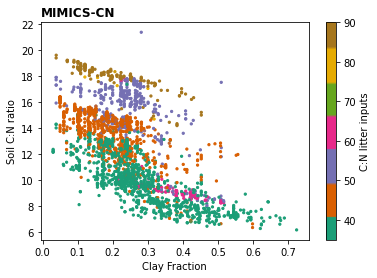

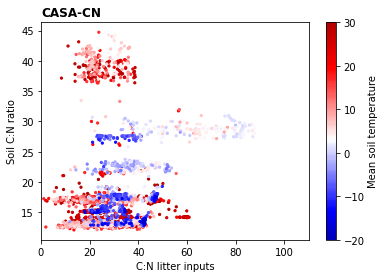

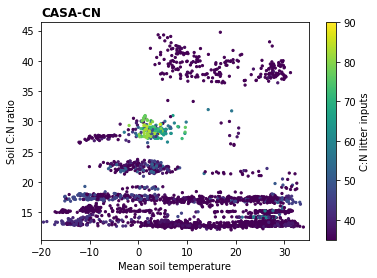

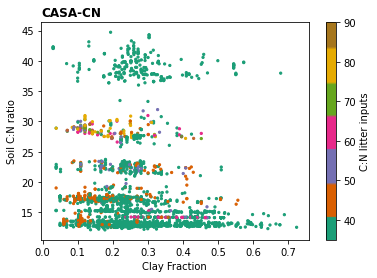

In [106]:
model = simLabs
sub = ['a','b','c']
j = 0
for i in [3,1]:
    ds_1 = ds.isel(time=slice(0,20), sim=i).mean('time')
    if i == 1:
        ds_1['cnLIT'] = (ds_1.cLitInptMet + ds_1.cLitInptStruc) / \
                         (ds_1.nLitInptMet + ds_1.nLitInptStruc)
    else:
        ds_1['cnLIT'] = (ds_1.cLitInput_metb + ds_1.cLitInput_struc) / \
                         (ds_1.nLitInput_metb + ds_1.nLitInput_struc)
    ds_1['cnLIT'].attrs['long_name'] = 'C:N litter inputs'

    # second plot litterCN vs. soilCN, color by temp
    color_by = ds_1.tsoilC
    label = 'Mean soil temperature'  # Need to rename if 'color_by' is changed

    fig, ax = plt.subplots()
    s = ax.scatter(ds_1['cnLIT'], ds_1['cnTOT'],
                   c=color_by,
                   s=5,
                   marker='o',                   # Plot circles
                  # alpha = 0.2,
                   cmap = utils.truncate_colormap(
                       cmapIn='seismic', minval=.15, maxval=.9),
                   vmin = -20,            # Min value
                   vmax = 30)             # Max value

    # Mappable 'maps' the values of s to an array of RGB colors 
    #  defined by a color palette
    cbar = plt.colorbar(mappable = s, ax = ax)   
    cbar.set_label(label)
    plt.xlabel(ds_1['cnLIT'].attrs['long_name'])
    plt.ylabel('Soil C:N ratio')
    plt.title(model[i],loc='left', fontsize='large', 
              fontweight='bold')
    ax.set_xlim(0, 110)
    plt.show();

    # second plot temp vs. soilCN, color by quality
    color_by = ds_1['cnLIT'] 
    label = ds_1['cnLIT'].attrs['long_name']
    fig, ax = plt.subplots()
    s = ax.scatter(ds_1.tsoilC, ds_1['cnTOT'],
                   c=color_by,
                   s=5,
                   marker='o',          # Plot circles
                   vmin = 35,           # Min value
                   vmax = 90)           # Max value

    # Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
    cbar = plt.colorbar(mappable = s, ax = ax)   
    cbar.set_label(label)
    plt.xlabel('Mean soil temperature')
    plt.ylabel('Soil C:N ratio')
    plt.title(model[i],loc='left', fontsize='large', 
              fontweight='bold')
    ax.set_xlim(-20, 35)
    plt.show();
    
    # 3rd plot clay vs. soilCN, color by quality
    color_by = ds_1['cnLIT'] 
    label = ds_1['cnLIT'].attrs['long_name']
    #fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), constrained_layout=True)
    fig, ax = plt.subplots()
    s = ax.scatter(ds_1.clay, ds_1['cnTOT'],
                   c=color_by,
                   s=5,
                   marker='o',          # Plot circles
                   #cmap = utils.truncate_colormap(
                   #    cmapIn='tab20b', minval=.1, maxval=0.9),
                   cmap = utils.truncate_colormap(
                       cmapIn='Dark2', minval=0.05, maxval=0.84),                   
                   vmin = 35,           # Min value
                   vmax = 90)           # Max value

    # Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
    cbar = plt.colorbar(mappable = s, ax = ax)   
    cbar.set_label(label)
    plt.xlabel('Clay Fraction')
    plt.ylabel('Soil C:N ratio')
    plt.title(model[i],loc='left', fontsize='large', 
              fontweight='bold')
    plt.show();
    j = j+1

**Figure 5** Temperature and litter stoichiometry interact to determine the soil C:N ratios that are simulated by MIMICS-CN. Points represent the gridcell mean annual stoichiometry of litterfall C:N fluxes that are simulated by the CASA-CNP vegetation model and resulting soil C:N ratios that are simulated by MIMICS.  The color of each point indicates mean annual soil temperature simulated by over the spin-up period (1901-1920). 


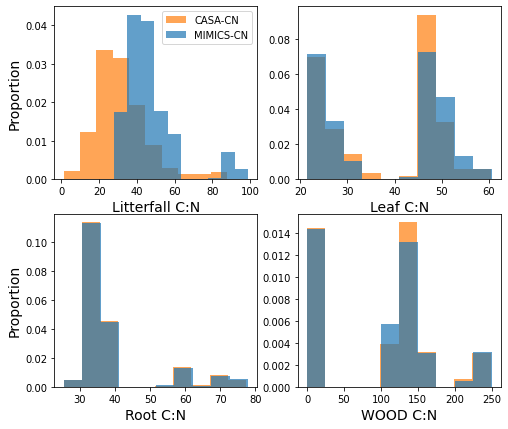

In [107]:
CAS_cnLIT = (ds.cLitInptMet + ds.cLitInptStruc) / \
            (ds.nLitInptMet + ds.nLitInptStruc)
CAS_cnLIT = CAS_cnLIT.isel(sim=1,time=slice(0,20)).mean('time')
MIM_cnLIT = ds.cnLIT.isel(sim=3,time=slice(0,20)).mean('time')

ds['cnLEAF'] = (ds.cleaf) / (ds.nleaf)
ds['cnROOT'] = (ds.cfroot) / (ds.nfroot)
ds['cnWOOD'] = (ds.cwood) / (ds.nwood)


# Histogram of the data
fig = plt.figure(figsize=[8,7])
kwargs = dict(bins=10, density=True, stacked=True,alpha=0.7)

plt.subplot(221)
plt.hist(CAS_cnLIT.values, **kwargs, facecolor=color[1], label="CASA-CN")
plt.hist(MIM_cnLIT.values, **kwargs, facecolor=color[2], label="MIMICS-CN")
plt.xticks([0,20,40,60,80,100])
plt.xlabel('Litterfall C:N', size=14)
plt.legend(loc='upper right')
plt.ylabel('Proportion', size=14)

plt.subplot(222)
plt.hist(ds.cnLEAF.isel(sim=1,time=slice(0,20)).mean('time').values, \
        **kwargs, facecolor=color[1], label="CASA-CN")
plt.hist(ds.cnLEAF.isel(sim=3,time=slice(0,20)).mean('time').values, \
        **kwargs, facecolor=color[2], label="MIMICS-CN")
plt.xlabel('Leaf C:N', size=14)

plt.subplot(223)
plt.hist(ds.cnROOT.isel(sim=1,time=slice(0,20)).mean('time').values, \
        **kwargs, facecolor=color[1], label="CASA-CN")
plt.hist(ds.cnROOT.isel(sim=3,time=slice(0,20)).mean('time').values, \
        **kwargs, facecolor=color[2], label="MIMICS-CN")
plt.xlabel('Root C:N', size=14)
plt.ylabel('Proportion', size=14)

plt.subplot(224)
plt.hist(ds.cnWOOD.isel(sim=1,time=slice(0,20)).mean('time').values, \
        **kwargs, facecolor=color[1], label="CASA-CN")
plt.hist(ds.cnWOOD.isel(sim=3,time=slice(0,20)).mean('time').values, \
        **kwargs, facecolor=color[2], label="MIMICS-CN")
plt.xlabel('WOOD C:N', size=14)
plt.ylabel(None)

plt.show()

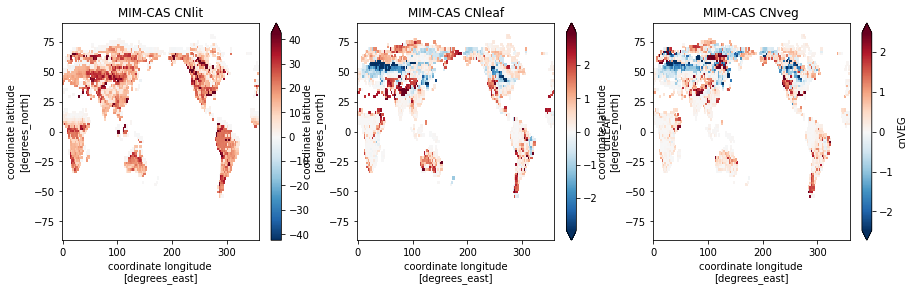

In [108]:
diffCNlit = MIM_cnLIT - CAS_cnLIT
diffCNleaf = ds.cnLEAF.isel(sim=3,time=slice(0,20)).mean('time') - \
             ds.cnLEAF.isel(sim=1,time=slice(0,20)).mean('time')

diffCNveg = ds.cnVEG.isel(sim=3,time=slice(0,20)).mean('time') - \
            ds.cnVEG.isel(sim=1,time=slice(0,20)).mean('time')

fig = plt.figure(figsize=[15,4])
plt.subplot(131)
diffCNlit.plot(robust=True)
plt.title('MIM-CAS CNlit')

plt.subplot(132)
diffCNleaf.plot(robust=True)
plt.title('MIM-CAS CNleaf') ;

plt.subplot(133)
diffCNveg.plot(robust=True)
plt.title('MIM-CAS CNveg') ;

In [109]:
ds

<xarray.Dataset>
Dimensions:              (lat: 96, lon: 144, sim: 4, time: 114)
Coordinates:
  * sim                  (sim) object 'CASA-C' 'CASA-CN' 'MIMICS-C' 'MIMICS-CN'
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
  * time                 (time) float32 1901.5013 1902.5013 ... 2014.5013
Data variables:
    day                  (sim, time, lat, lon) float64 nan nan nan ... nan nan
    IGBP_PFT             (sim, lat, lon) float64 nan nan nan nan ... nan nan nan
    landarea             (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cellMissing          (sim, lat, lon) float64 nan nan nan nan ... nan nan nan
    cellid               (sim, lat, lon) float64 nan nan nan nan ... nan nan nan
    cLITm                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cLITs                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cMICr                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cMICk                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMa                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMc                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMp                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cHresp               (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMpIn              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cLitInput_metb       (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cLitInput_struc      (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cOverflow_r          (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cOverflow_k          (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLITm                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLITs                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nMICr                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nMICk                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nSOMa                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nSOMc                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nSOMp                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    DIN                  (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLitInput_metb       (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLitInput_struc      (sim, lat, lon, time) float32 nan nan nan ... nan nan
    thetaLiq             (sim, lat, lon, time) float32 nan nan nan ... nan nan
    thetaFrzn            (sim, lat, lon, time) float32 nan nan nan ... nan nan
    fW                   (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cresp                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cnpp                 (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cgpp                 (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cleaf                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nleaf                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cwood                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nwood                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cfroot               (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nfroot               (sim, lat, lon, time) float32 nan nan nan ... nan nan
    clitmetb             (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nlitmetb             (sim, lat, lon, time) float32 nan nan nan ... nan nan
    clitstr              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nlitstr              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    clitcwd              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nlitcwd            

### Try a 3d plot showing relationships with stoichiometry and temperature for litter, biomass, soil 

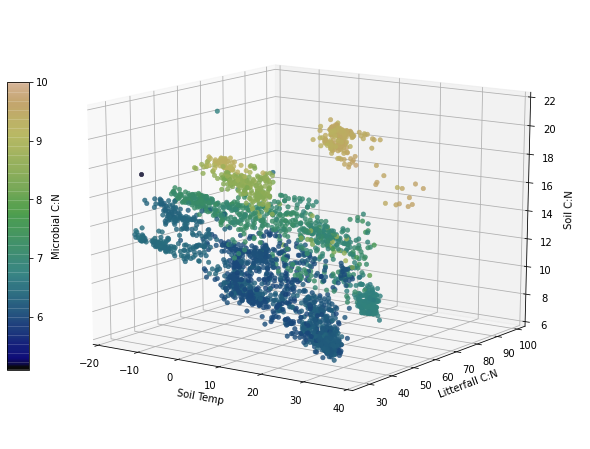

In [110]:
ds_1 = ds.isel(time=slice(0,20), sim=3).mean('time')
y = ds_1['cnLIT'].values.ravel()
x = ds_1['tsoilC'].values.ravel()
z = ds_1['cnTOT'].values.ravel()
zz = ds_1['cnMIC'].values.ravel()


fig = plt.figure(figsize=[10,8])
ax = fig.gca(projection='3d')
surf = ax.scatter(x, y, z, linewidth=0.5, antialiased=True, 
                  c = zz, marker='o', alpha=0.8,
                  cmap = utils.truncate_colormap(cmapIn='gist_earth', minval=.0, maxval=.85),
                  vmin = 5.1, vmax = 10,
                 )        
ax.set_xlim(-20, 40)
#ax.set_ylim(-20, 40)
ax.set_zlim(6, 22)
ax.set_ylabel('Litterfall C:N')
ax.set_xlabel('Soil Temp')
ax.set_zlabel('Soil C:N');
# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([0.1, 0.25, 0.03, 0.5])  # This is the position for the colorbar
cb = fig.colorbar(surf, cax = cbaxes, shrink=0.5, aspect=8,
             label='Microbial C:N')
fig.set_label('Litterfall C:N')
ax.view_init(15, -55)
plt.draw()


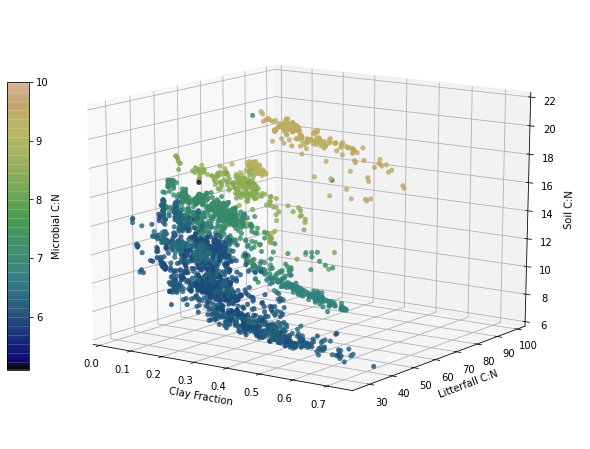

In [111]:
ds_1 = ds.isel(time=slice(0,20), sim=3).mean('time')
y = ds_1['cnLIT'].values.ravel()
x = ds_1['clay'].values.ravel()
z = ds_1['cnTOT'].values.ravel()
zz = ds_1['cnMIC'].values.ravel()


fig = plt.figure(figsize=[10,8])
ax = fig.gca(projection='3d')
surf = ax.scatter(x, y, z, linewidth=0.5, antialiased=True, 
                  c = zz, marker='o', alpha=0.8,
                  cmap = utils.truncate_colormap(cmapIn='gist_earth', minval=.0, maxval=.85),
                  vmin = 5.1, vmax = 10,
                 )        
#ax.set_xlim(0,0.60)
#ax.set_ylim(-20, 40)
ax.set_zlim(6, 22)
ax.set_ylabel('Litterfall C:N')
ax.set_xlabel('Clay Fraction')
ax.set_zlabel('Soil C:N');
# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([0.1, 0.25, 0.03, 0.5])  # This is the position for the colorbar
cb = fig.colorbar(surf, cax = cbaxes, shrink=0.5, aspect=8,
             label='Microbial C:N')
fig.set_label('Litterfall C:N')
ax.view_init(15, -55)
plt.draw()


In [112]:
#print(dt1.lit_cn.groupby(dt1.location_name.unique()))
#plt.plot(dt1.location_name,dt1.lit_cn)

-----------
### Annual cycle of fluxes
This can be done for grid cells, or zonally

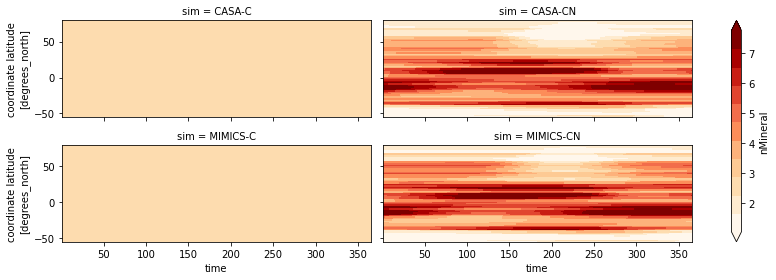

In [113]:
dsDay['Nlimit'] = dsDay['cnpp'] - dsDay['cnpp'].isel(sim=0)

var = ['cMICtot','nMineral','cresp',
       'nNetMineralization','MICrK','cnMIC','cnpp','NEP',
       'Nlimit','tsoilC']
v = 1
dsDay.isel(time=slice(0,365))[var[v]].mean(
    dim='lon').sel(lat=slice(-55,80)).plot(
    x='time', y="lat", col="sim", robust=True,
    cmap=cm.get_cmap('OrRd', 11), #BrBG for NEP
    figsize=[12,4],col_wrap=2);

- Above: Positive NEP = land C uptake, 
Negative = release to atmosphere
- Below: red = MIMICS > CASA

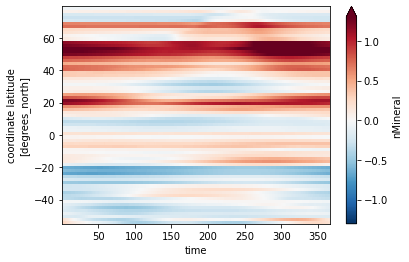

In [114]:
## Mimics - CASA
MCdiff = dsDay.isel(sim=3) - dsDay.isel(sim=1)
MCdiff.isel(time=slice(0,365))[var[v]].mean(
    dim='lon').sel(lat=slice(-55,80)).plot(
    x='time', y="lat", robust=True,
    figsize=[6,4]);

In [115]:
dsDay

<xarray.Dataset>
Dimensions:              (lat: 96, lon: 144, sim: 4, time: 730)
Coordinates:
  * sim                  (sim) object 'CASA-C' 'CASA-CN' 'MIMICS-C' 'MIMICS-CN'
  * time                 (time) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
Data variables:
    day                  (sim, time, lat, lon) float64 nan nan nan ... nan nan
    IGBP_PFT             (sim, lat, lon, time) float64 nan nan nan ... nan nan
    landarea             (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cellMissing          (sim, lat, lon, time) float64 nan nan nan ... nan nan
    cellid               (sim, lat, lon, time) float64 nan nan nan ... nan nan
    cLITm                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cLITs                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cMICr                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cMICk                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMa                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMc                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMp                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cHresp               (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cSOMpIn              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cLitInput_metb       (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cLitInput_struc      (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cOverflow_r          (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cOverflow_k          (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLITm                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLITs                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nMICr                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nMICk                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nSOMa                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nSOMc                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nSOMp                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    DIN                  (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLitInput_metb       (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nLitInput_struc      (sim, lat, lon, time) float32 nan nan nan ... nan nan
    thetaLiq             (sim, lat, lon, time) float32 nan nan nan ... nan nan
    thetaFrzn            (sim, lat, lon, time) float32 nan nan nan ... nan nan
    fW                   (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cresp                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cnpp                 (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cgpp                 (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cleaf                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nleaf                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cwood                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nwood                (sim, lat, lon, time) float32 nan nan nan ... nan nan
    cfroot               (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nfroot               (sim, lat, lon, time) float32 nan nan nan ... nan nan
    clitmetb             (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nlitmetb             (sim, lat, lon, time) float32 nan nan nan ... nan nan
    clitstr              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nlitstr              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    clitcwd              (sim, lat, lon, time) float32 nan nan nan ... nan nan
    nlitcwd              

### Looking at annual cycle of fluxes in regions
- large mineral N accumulation in ag regions from MIMICS
- spatial distinct from regions with N limitation

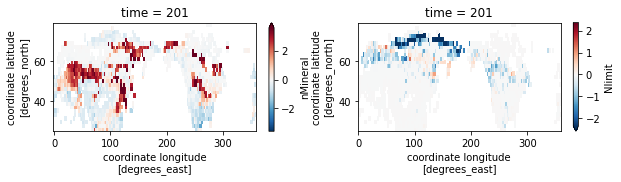

In [116]:
plt.figure(figsize=[10,2])
plt.subplot(121)
(dsDay.nMineral.isel(sim=3) - dsDay.nMineral.isel(sim=1)).isel(time=200).sel(lat=slice(25,80)).plot(robust=True) ;
plt.subplot(122)
(dsDay.Nlimit.isel(sim=3) - dsDay.Nlimit.isel(sim=1)).isel(time=200).sel(lat=slice(25,80)).plot(robust=True) ;

In [117]:
print(var)
dsDay[var[1]].attrs

['cMICtot', 'nMineral', 'cresp', 'nNetMineralization', 'MICrK', 'cnMIC', 'cnpp', 'NEP', 'Nlimit', 'tsoilC']


{'long_name': 'Mineral Soil N', 'units': 'gN m-2'}

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_exudate0_cwdN_Fig_7_regional fluxes.pdf --


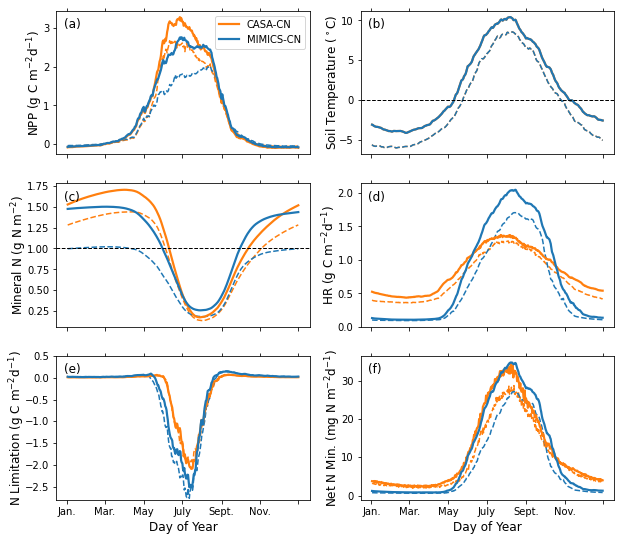

In [118]:
plt.figure(figsize=[10,9])
latmin, latmax = 60,70
lonmin, lonmax = 0,100

ylab = ['NPP','Soil Temperature',
        'Mineral N', 'HR',
        'N Limitation','Net N Min.']
units = ['g C $\mathregular{m^{-2 } d^{-1}}$',
         '$^\circ$C',
         'g N $\mathregular{m^{-2 }}$',
         'g C $\mathregular{m^{-2 } d^{-1}}$',
         'g C $\mathregular{m^{-2 } d^{-1}}$',
         'mg N $\mathregular{m^{-2 } d^{-1}}$']

j = 1
for i in [6,9,1,2,8,3]:#,8,3,1]:
    temp = globalMean(dsDay[var[i]].sel(lat=slice(latmin, latmax),
                                        lon=slice(lonmin,lonmax)), 
                     area=ds.landarea.isel(sim=nsim-1).sel(lat=slice(latmin, latmax),
                                                           lon=slice(lonmin,lonmax)) *1e6, 
                     timeC=1, conversion=1, units='gC/m2/d', pt=False)
    if i == 3: #convert N min to mgN/m2/dv
        temp=temp*1e3
        
    # Start plotting
    # control axes
    plt.rcParams['xtick.top'] = True 
    plt.rcParams['ytick.right'] = False 
    if j <= 4: 
        plt.rcParams['xtick.labelbottom'] = False
    else:    
        plt.rcParams['xtick.labelbottom'] = True

    # make subplots
    plt.subplot(3, 2, j)
    plt.plot(temp.isel(time=slice(0,365)).time,
             temp.isel(sim=1,time=slice(0,365)) , '--',
             color='tab:orange', linewidth=1.5) 
    plt.plot(temp.isel(time=slice(0,365)).time,
             temp.isel(sim=3,time=slice(0,365)) , '--',
             color='tab:blue', linewidth=1.5) 
    plt.plot(temp.isel(time=slice(365,None)).time,
             temp.isel(sim=1,time=slice(365,None)) , '-',
             color='tab:orange', linewidth=2.2, label="CASA-CN") 
    plt.plot(temp.isel(time=slice(365,None)).time,
             temp.isel(sim=3,time=slice(365,None)) , '-',
             color='tab:blue', linewidth=2.2, label="MIMICS-CN") 
    plt.ylabel(ylab[(j-1)] + ' ('+ units[(j-1)] + ')',size='large', labelpad=-2)
    #plt.annotate(panel[0], ha='center', va='center',fontsize=16,
    #        bbox=dict(facecolor='white', alpha=0.8,edgecolor='none'))    
    if j == 0:# or j ==4:   #changes to j =1 or 4 to add C-only results for NPP, HR 
        plt.plot(temp.isel(time=slice(0,365)).time,
                 temp.isel(sim=0,time=slice(0,365)) , '--',
                 color='tab:red') 
        plt.plot(temp.isel(time=slice(365,None)).time,
             temp.isel(sim=0,time=slice(365,None)) , '-',
             color='tab:red') 
    # format individual plots
    if j == 1: plt.legend()
    if j == 2: plt.axhline(y=0., color='k', linestyle='--', linewidth=1)
    if j == 3: plt.axhline(y=1., color='k', linestyle='--', linewidth=1)
    if j == 5: 
        plt.ylim(-2.8,0.5)
        #plt.axhline(y=0., color='k', linestyle='--', linewidth=1)
    #if j == 4: plt.yticks([0, 0.5,1.0,1.5,2.0,2.5,])
    if j >  4: plt.xlabel('Day of Year',size='large')
    # add panel labels
    plt.text(0.03, 0.88, panel[(j-1)], transform=plt.gca().transAxes, size='large')
    plt.xticks([0, 60,121,182,244,305,365,],['Jan.','Mar.','May','July','Sept.','Nov.'])
    j = j+1

if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_7_regional fluxes.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;


In [119]:
var

['cMICtot',
 'nMineral',
 'cresp',
 'nNetMineralization',
 'MICrK',
 'cnMIC',
 'cnpp',
 'NEP',
 'Nlimit',
 'tsoilC']

-- cum cMICtot --
MIMICS-CN
  1901-05 = 48882.684
  2010-14 = 51191.555
CASA-CN
  1901-05 = 0.0
  2010-14 = 0.0
-- cum nMineral --
MIMICS-CN
  1901-05 = 275.44202
  2010-14 = 398.86407
CASA-CN
  1901-05 = 352.11148
  2010-14 = 418.2025
-- cum cresp --
MIMICS-CN
  1901-05 = 216.51088
  2010-14 = 282.01273
CASA-CN
  1901-05 = 265.5521
  2010-14 = 303.3397
-- cum nNetMineralization --
MIMICS-CN
  1901-05 = 2.7902088
  2010-14 = 3.886407
CASA-CN
  1901-05 = 3.5274007
  2010-14 = 4.229328
-- cum MICrK --
MIMICS-CN
  1901-05 = 337.22922
  2010-14 = 337.04266
CASA-CN
  1901-05 = 0.0
  2010-14 = 0.0
-- cum cnMIC --
MIMICS-CN
  1901-05 = 3080.7937
  2010-14 = 3034.6013
CASA-CN
  1901-05 = 0.0
  2010-14 = 0.0
-- cum cnpp --
MIMICS-CN
  1901-05 = 216.6953
  2010-14 = 291.09473
CASA-CN
  1901-05 = 264.78824
  2010-14 = 313.32684
-- cum NEP --
MIMICS-CN
  1901-05 = 0.184352
  2010-14 = 9.081742
CASA-CN
  1901-05 = -0.7637318
  2010-14 = 9.987165
MIMICS-Conly
  1901-05 = 7.699393
  2010-14 = -12.040

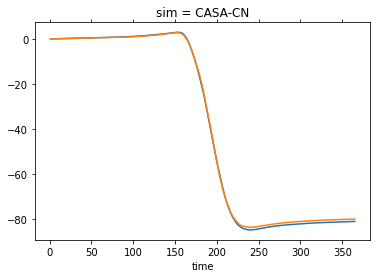

In [120]:
#print climatology cumulative sum:
# Todo, these results really only make sense for C fluxes
for v in range(len(var)):
    temp = globalMean(dsDay[var[v]].sel(lat=slice(latmin, latmax),
                                        lon=slice(lonmin,lonmax)), 
                        area=ds.landarea.isel(sim=nsim-1).sel(lat=slice(latmin, latmax),
                                                              lon=slice(lonmin,lonmax)) *1e6, 
                        timeC=1, conversion=1, units='gC/m2/d', pt=False)
    print('-- cum '+var[v]+" --")
    print('MIMICS-CN')
    print('  1901-05 = '+str(temp.isel(sim=3,time=slice(0,365)).cumsum().values[-1]) )
    print('  2010-14 = '+str(temp.isel(sim=3,time=slice(365,None)).cumsum().values[-1]) )
    print('CASA-CN')
    print('  1901-05 = '+str(temp.isel(sim=1,time=slice(0,365)).cumsum().values[-1]) )
    print('  2010-14 = '+str(temp.isel(sim=1,time=slice(365,None)).cumsum().values[-1]) )

    if v == 7:
        print('MIMICS-Conly')
        print('  1901-05 = '+str(temp.isel(sim=2,time=slice(0,365)).cumsum().values[-1]) )
        print('  2010-14 = '+str(temp.isel(sim=2,time=slice(365,None)).cumsum().values[-1]) )
        print('CASA-Conly')
        print('  1901-05 = '+str(temp.isel(sim=0,time=slice(0,365)).cumsum().values[-1]) )
        print('  2010-14 = '+str(temp.isel(sim=0,time=slice(365,None)).cumsum().values[-1]) )
    
    if v == 8:
        temp.isel(sim=1,time=slice(0,365)).cumsum().plot()
        temp.isel(sim=1,time=slice(365,None)).cumsum().plot() ;

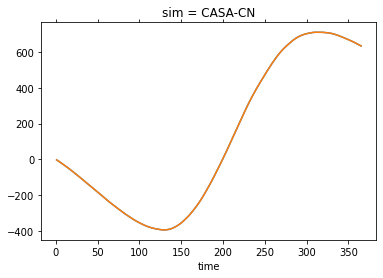

In [121]:
temp.isel(sim=3,time=slice(365,None)).cumsum().plot()
temp.isel(sim=1,time=slice(365,None)).cumsum().plot()


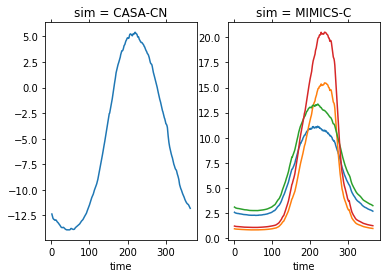

In [122]:
plt.subplot(1, 2, 1)
temp = globalMean(dsDay['tsoilC'].sel(lat=slice(latmin, latmax)), 
                     area=ds.landarea.isel(sim=nsim-1).sel(lat=slice(latmin, latmax)) *1e6, 
                     timeC=1, conversion=1, units='gC/m2/d', pt=False)
temp.isel(sim=1, time=slice(0,365)).plot()

plt.subplot(1, 2, 2)
temp = globalMean(dsDay['cresp'].sel(lat=slice(latmin, latmax)), 
                     area=ds.landarea.isel(sim=nsim-1).sel(lat=slice(latmin, latmax)) *1e6, 
                     timeC=1, conversion=1, units='gC/m2/d', pt=False)
(temp.isel(sim=1, time=slice(0,365))*10).plot()
(temp.isel(sim=3, time=slice(0,365))*10).plot()
(temp.isel(sim=0, time=slice(0,365))*10).plot()
(temp.isel(sim=2, time=slice(0,365))*10).plot()

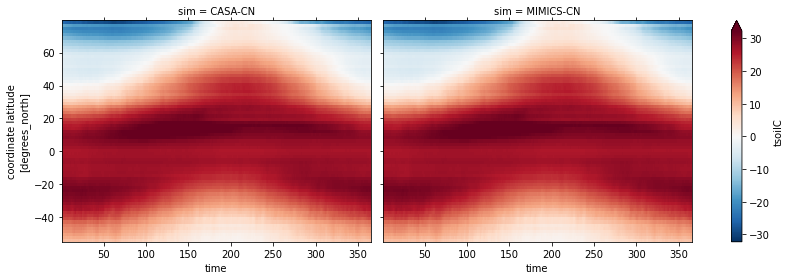

In [123]:
dsDay.isel(time=slice(365,None),sim=CNsim)[var[v]].mean(
    dim='lon').sel(lat=slice(-55,80)).plot(
    x='time', y="lat", col="sim", robust=True,
    figsize=[12,4],col_wrap=2);

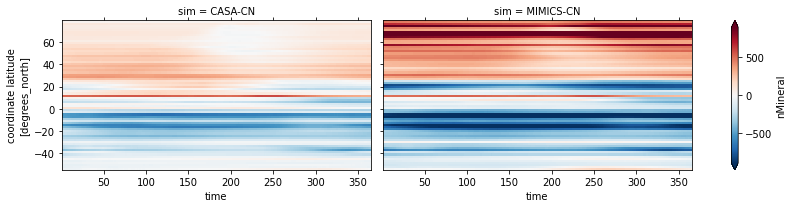

In [124]:
#change in daily fluxes
v=1
d_dsDay0 = dsDay.isel(time=slice(0,365)) 
d_dsDay1 = dsDay.isel(time=slice(365,None)) 
d_dsDay1 = d_dsDay1-d_dsDay0
(d_dsDay1[var[v]].mean(dim='lon')*365).sel(lat=slice(-55,80)).isel(sim=[1,3]).plot(
    x='time',y="lat", col="sim", robust=True,
    figsize=[12,3],col_wrap=2);

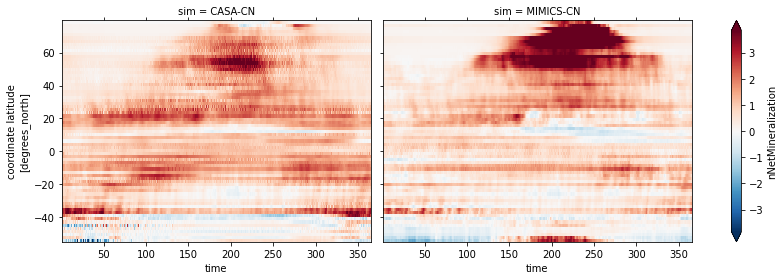

In [125]:
# Differences betweeen models (MIMICS-CASA)
v = 3
(d_dsDay1.isel(sim=CNsim)[var[v]].mean(
    dim='lon')*365).sel(lat=slice(-55,80)).plot(
    x='time',y="lat", col="sim", robust=True,
    figsize=[12,4],col_wrap=2);

In [126]:
print((ds.cLitInput_metb / (ds.cLitInput_metb+ds.cLitInput_struc)).isel(time=slice(0,20),sim=3).mean('time').min())
(ds.cLitInput_metb / (ds.cLitInput_metb+ds.cLitInput_struc)).isel(time=slice(0,20),sim=3).mean('time').max()

<xarray.DataArray ()>
array(0.32315272)
Coordinates:
    sim      <U9 'MIMICS-CN'


<xarray.DataArray ()>
array(0.59719563)
Coordinates:
    sim      <U9 'MIMICS-CN'